# Figure 5: MHC class II vs CH risk
## modelled on the script used to do MHC class I so we analyse everything in the same way

## Import packages

In [2]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


In [3]:

axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [4]:

timestr = time.strftime("%Y%m%d") # get current date 

## Import batch data

In [5]:

folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [6]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2,55,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4,82,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2,103,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2,96,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8,61,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2,72,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2,78,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2,92,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2,59,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4,41,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [7]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


## Annotate samples with genetic variants carried

In [8]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 

# we have more variants than sites because for each site, we look at any change from the reference sequence (any possible variant)
# at the same time, because we have this data, we can check if we have more variants that "random" mutations

# save coordinates to a df
pd.DataFrame(num_variants.variant_coord_pos.unique().tolist()).to_csv('/Users/barbarawalkowiak/Desktop/variants_annotated.csv')

Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [9]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [10]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


## Add age data

In [11]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [12]:

# add age data to the rest of the data 

batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant:", batch_gene_vars.shape[0])
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0]) # these are healthy / non-cancer cases (can think if we want to filter out the cancer ones, but tbf probably yes)
# note: this is throwing away patients who have been diagnosed with cancer (this dataset is for healthy individuals only)

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986


# Load MHC class II genotype data

In [14]:

# add MHC genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lack full genotype data
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lack full genotype data

# we will analyse DR and DP / DQ alleles separately because the "rules" are different (ie alpha / beta chain combinations etc.)
# NOTE: I am removing samples for which we don't have correct allele annotation
df_hla2_dp = df_clean_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_clean_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_clean_hla2.filter(regex='^(Person_|DR)')

print("Number of samples with MHC II genotype imputation data", df_hla2.shape[0])
print("Number of samples with MHC II genotype confidently imputed", df_clean_hla2.shape[0]) # not ideal as this really throws out a lot of the data we have actually 

Number of samples with MHC II genotype imputation data 488377
Number of samples with MHC II genotype confidently imputed 378317


In [15]:

# okay, a problem with DP / DQ is that we have predictions for COMBINATIONS
# therefore, we need to create columns with combinations and use them for when we make the prediction

# what we can do is create additional columns and set the value to 1 if someone has both alleles (who knows if they will have the combination
# but if predictions are available for it in NetMHCII we can assume that maybe it's legit)

from itertools import combinations

# combinations for DQ
cc = list(combinations(df_hla2_dq.columns[1:],2)) # possible combinations of these columns (first is Person_ID)
df_hla2_dq_comb = pd.concat([df_hla2_dq[c[0]].multiply(df_hla2_dq[c[1]]) for c in cc], axis=1, keys=cc) 
# we are multiplying
# in this way, if someone has >= 1 in both alleles they will get a positive number
# even if they have 2 alleles in one allele but 0 in the other, they will get a zero

df_hla2_dq_comb.columns = df_hla2_dq_comb.columns.map('-'.join) # join with a '-'

# repeat the same for DP 
cc = list(combinations(df_hla2_dp.columns[1:],2)) # possible combinations of these columns (first is Person_ID)
df_hla2_dp_comb = pd.concat([df_hla2_dp[c[0]].multiply(df_hla2_dp[c[1]]) for c in cc], axis=1, keys=cc) 
# we are multiplying
# in this way, if someone has >= 1 in both alleles they will get a positive number
# even if they have 2 alleles in one allele but 0 in the other, they will get a zero

df_hla2_dp_comb.columns = df_hla2_dp_comb.columns.map('-'.join) # join with a '-'


In [16]:
# okay, now: we do not want to predict stuff for 2 alpha or 2 beta chains because these are not created so we can remove these columns
# we also want to rename columns from XXB-XXA to XXA-XXB
def is_valid_column_name(col):
    parts = col.split('-') # two part of the name of the column
    return 'A' in parts[0] and 'B' in parts[1] or 'B' in parts[0] and 'A' in parts[1]

def switch_parts(col):
    parts = col.split('-') 
    new_name = parts[1] + '-' + parts[0]
    return new_name

In [17]:

# remove columns with BB or AA combinations 
filtered_columns_dp = [col for col in df_hla2_dp_comb.columns if is_valid_column_name(col)]
filtered_columns_dq = [col for col in df_hla2_dq_comb.columns if is_valid_column_name(col)]

# Create a new DataFrame with the filtered and reordered columns
new_df_dp = df_hla2_dp_comb[filtered_columns_dp]
new_df_dq = df_hla2_dq_comb[filtered_columns_dq]

renamed_columns_dp = [switch_parts(col) for col in new_df_dp.columns]
renamed_columns_dq = [switch_parts(col) for col in new_df_dq.columns]

new_df_dp.columns = renamed_columns_dp
new_df_dq.columns = renamed_columns_dq

In [18]:

# once we have selected the correct columns, combine with other data

# DP
df_hla2_dp_all = pd.concat([df_hla2_dp, new_df_dp], axis = 1)
df_hla2_dp_all.replace(2, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1
df_hla2_dp_all.replace(4, 1, inplace=True) # if someone got a 2 (2 * 2), replace to 1
df_hla2_dp_all

# let's remove columns where noone has the combination (it's possible that some combinations are never seen in our dataset)
colsums = pd.DataFrame(df_hla2_dp_all.sum()).reset_index()
colsums.rename(columns={'index': 'col_name', 0:'col_sum'}, inplace=True)
col_to_retain = colsums[colsums['col_sum']>=1]['col_name'] # these are the columns to retain 
df_hla2_dp_all = df_hla2_dp_all[col_to_retain]
df_hla2_dp_all 

# DQ
df_hla2_dq_all = pd.concat([df_hla2_dq, new_df_dq], axis = 1)
df_hla2_dq_all.replace(2, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1
df_hla2_dq_all.replace(4, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1
df_hla2_dq_all

# let's remove columns where noone has the combination (it's possible that some combinations are never seen in our dataset)
colsums = pd.DataFrame(df_hla2_dq_all.sum()).reset_index()
colsums.rename(columns={'index': 'col_name', 0:'col_sum'}, inplace=True)
col_to_retain = colsums[colsums['col_sum']>=1]['col_name'] # these are the columns to retain 
df_hla2_dq_all = df_hla2_dq_all[col_to_retain]
df_hla2_dq_all 

,Person_ID,DQB1_201,DQB1_202,DQB1_301,DQB1_302,DQB1_303,DQB1_304,DQB1_401,DQB1_402,DQB1_501,...,DQA1_102-DQB1_609,DQA1_103-DQB1_609,DQA1_201-DQB1_609,DQA1_301-DQB1_609,DQA1_302-DQB1_609,DQA1_303-DQB1_609,DQA1_401-DQB1_609,DQA1_501-DQB1_609,DQA1_505-DQB1_609,DQA1_601-DQB1_609
1,4860169,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3381323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2805252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3318036,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4120291,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488370,4478244,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488373,3573995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488374,1206874,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488375,3025735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load MHC binding affinity prediction

In [19]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [20]:

# parameters
param = '%Rank_EL' # let's do it on EL ranks first 

# NOTE: In the original file (sub), I was missing a score for DNMT3A_R736C_ch so I generated it separately with the same code and will concatenate the files here 
# load the file with binding predictions across variants
pred_file_dpq_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240211_NetMHC_HLA_UKBB_with_affinities_DP_DQ_bestscores.csv"
pred_file_dpq_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DP_DQ_R736C_bestscores.csv"
pred_file_dpq_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DP_DQ_stopcodons_bestscores.csv"
pred_method = pred_file_dpq_sub.split('_out')[0] # all are with the same method so does not matter which file you end up using 
 
# organize file with prediction scores for DP and DQ alleles 
pred_filename_dpq_sub = pred_file_dpq_sub.split('/')[2].split('.')[0]
pred_filename_dpq_stop = pred_file_dpq_stop.split('/')[2].split('.')[0]
pred_df_dpq_sub = pd.read_csv(pred_file_dpq_sub)
pred_df_dpq_r736c = pd.read_csv(pred_file_dpq_r736c)
pred_df_dpq_stop = pd.read_csv(pred_file_dpq_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dpq_sub = pred_df_dpq_sub[~pred_df_dpq_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dpq = pd.concat([pred_df_dpq_sub, pred_df_dpq_stop, pred_df_dpq_r736c], ignore_index = True)
pred_df_dpq['gene_var_gt'] = pred_df_dpq['gene'] + '_' + pred_df_dpq['variant'] + '_' + pred_df_dpq['genotype'] # create a column that includes all genotype data

# organize file with prediction scores for DR alleles 
pred_file_dr_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_bestscores.csv"
pred_file_dr_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DR_R736C_bestscores.csv"
pred_file_dr_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_stopcodons_bestscores.csv"

# organize file with prediction scores for DP and DQ alleles 
pred_filename_dr_sub = pred_file_dr_sub.split('/')[2].split('.')[0]
pred_filename_dr_stop = pred_file_dr_stop.split('/')[2].split('.')[0]
pred_df_dr_sub = pd.read_csv(pred_file_dr_sub)
pred_df_dr_r736c = pd.read_csv(pred_file_dr_r736c)
pred_df_dr_stop = pd.read_csv(pred_file_dr_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dr_sub = pred_df_dr_sub[~pred_df_dr_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dr = pd.concat([pred_df_dr_sub, pred_df_dr_stop, pred_df_dr_r736c], ignore_index = True)
pred_df_dr['gene_var_gt'] = pred_df_dr['gene'] + '_' + pred_df_dr['variant'] + '_' + pred_df_dr['genotype'] # create a column that includes all genotype data
pred_df_dr.head(n = 5)


,Unnamed: 0,Pos,HLA,Peptide,Of,Core,Core_Rel,Inverted,Identity,Score_EL,...,BindLevel,gene,variant,genotype,gene_var,Score_BA,%Rank_BA,Affinity (nM),Affinity(nM),gene_var_gt
0,81173,1,DRB1_0101,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.035335,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
1,81178,1,DRB1_0102,SVPVIRHLFALLKEY,4,IRHLFALLK,0.96,0,seq_5,0.075223,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
2,81191,1,DRB1_0103,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.015829,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
3,81196,1,DRB1_0301,SVPVIRHLFALLKEY,4,IRHLFALLK,0.92,0,seq_5,0.003383,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
4,81206,1,DRB1_0302,VPVIRHLFALLKEYF,3,IRHLFALLK,0.89,0,seq_6,0.003467,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch


In [21]:

# we need to move the format of the DP/DQ predictions to something that matches our UKBB genotyping and everything else 
def transform_format_DPQ(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w{3})(\d{1})(\d{4})-(\w{3})(\d{1})(\d{4})') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 
        group4 = match.group(4) # name of the second allele in the combination
        group5 = int(match.group(5)) # there will be no zeroes, leave as it is 
        group6 = int(match.group(6)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}-{group4}{group5}_{group6}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0

def transform_format_DR(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'(\w{3})(\d{1})_(\d+)') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0


In [22]:

pred_df_dpq['HLA_formatted'] = pred_df_dpq['HLA'].map(transform_format_DPQ)
pred_df_dr['HLA_formatted'] = pred_df_dr['HLA'].map(transform_format_DR)

In [23]:

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
batch_gene_age.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
ids_batch = batch_gene_age['Person_ID']
hla_batch_ids_dr = df_hla2_dr[df_hla2_dr['Person_ID'].isin(ids_batch)] 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_age_hla_dr = pd.merge(batch_gene_age, df_hla2_dr, on='Person_ID')
batch_gene_age_hla_dp = pd.merge(batch_gene_age, df_hla2_dp_all, on='Person_ID')
batch_gene_age_hla_dq = pd.merge(batch_gene_age, df_hla2_dq_all, on='Person_ID')

batch_gene_hla_dr = pd.merge(batch_gene_vars, df_hla2_dr, on='Person_ID')
batch_gene_hla_dp = pd.merge(batch_gene_vars, df_hla2_dp_all, on='Person_ID')
batch_gene_hla_dq = pd.merge(batch_gene_vars, df_hla2_dq_all, on='Person_ID')

print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print('Number of samples with annotated variants CH variant and HLA genotype (DR):', batch_gene_hla_dr.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and HLA genotype (DP):', batch_gene_hla_dp.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and HLA genotype (DQ):', batch_gene_hla_dq.shape[0]) # 1 HLA genotype missing 
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype (DR):', batch_gene_age_hla_dr.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DP):', batch_gene_age_hla_dp.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DQ):', batch_gene_age_hla_dq.shape[0]) # 1 HLA genotype missing 


Number of samples with available CH variant: 2249
Number of samples with annotated variants CH variant and HLA genotype (DR): 1746
Number of samples with annotated variants CH variant and HLA genotype (DP): 1746
Number of samples with annotated variants CH variant and HLA genotype (DQ): 1746
Number of samples with available CH variant and age: 1986
Number of samples with annotated variants CH variant and age and HLA genotype (DR): 1539
Number of samples with annotated variants CH variant and age and HLA genotype (DP): 1539
Number of samples with annotated variants CH variant and age and HLA genotype (DQ): 1539


# Add scores based on MHC class II genotype

In [24]:

# oki basically we need to figure out what is wrong with this function

# define function to find the best score for the variant that is carried (ie present in the person)
def find_best_score_for_variant_carried(row, df, param):

    '''
    This functiion is applied to the CH dataset
    The df is the dataset with predictions for given allele and genetic variant 
    parameter is what to base this prediction on (here will only be using %Rank_EL)
    '''
    
    # these are the values of rows to seach for 
    row_values = pd.to_numeric(row[1:-1], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-1][row_values >= 1]  
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        # note here we will only be using '%Rank_EL'
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value  

In [25]:

# do this for DR alleles 
param = '%Rank_EL'

# DR
pred_sub_dr = pred_df_dr[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dr_wide = pd.pivot(pred_sub_dr, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dr_wide = pred_sub_dr_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dr = batch_gene_age_hla_dr.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dr = pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.isin(hla_ukbb_dr)] # HLA in the UKBB which I have predictions for 
hla_intersect_dr_list = hla_intersect_dr.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dr = pred_sub_dr_wide[hla_intersect_dr_list + pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dr = pred_sub_dr[pred_sub_dr['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dr = batch_gene_age_hla_dr[hla_intersect_dr_list + batch_gene_age_hla_dr.columns[batch_gene_age_hla_dr.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dr = pd.concat([batch_gene_age_hla_dr["Person_ID"], ch_hla_sub_dr], axis=1) # add CH cases 
ch_hla_sub_dr['score'] = ch_hla_sub_dr.apply(find_best_score_for_variant_carried, df=pred_sub_dr, param=param, axis=1) # add score for the parameter
ch_hla_scores_dr = ch_hla_sub_dr.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dr = batch_gene_age_hla_dr[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dr = pd.merge(ch_hla_scores_dr, age_vaf_dr, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dr = ch_hla_merge_dr[col_to_select]
ch_hla_merge_sub_dr['log_score'] = -1*np.log10(ch_hla_merge_sub_dr['score']) # convert score to -log10(score)
ch_hla_merge_sub_dr['allele_type'] = 'DR'


In [26]:

# DP
pred_sub_dpq = pred_df_dpq[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dpq = pred_sub_dpq[~pred_sub_dpq.duplicated()] # remove duplicate columns 
pred_sub_dpq_reset = pred_sub_dpq.reset_index()
pred_sub_dpq_wide = pd.pivot(pred_sub_dpq_reset, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dpq_wide = pred_sub_dpq_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dp = batch_gene_age_hla_dp.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dp = pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.isin(hla_ukbb_dp)] # HLA in the UKBB which I have predictions for 
hla_intersect_dp_list = hla_intersect_dp.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dp = pred_sub_dpq_wide[hla_intersect_dp_list + pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dp = pred_sub_dp[pred_sub_dp['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dp = batch_gene_age_hla_dp[hla_intersect_dp_list + batch_gene_age_hla_dp.columns[batch_gene_age_hla_dp.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dp = pd.concat([batch_gene_age_hla_dp["Person_ID"], ch_hla_sub_dp], axis=1) # add CH cases 
ch_hla_sub_dp['score'] = ch_hla_sub_dp.apply(find_best_score_for_variant_carried, df=pred_sub_dp, param=param, axis=1) # add score for the parameter
ch_hla_scores_dp = ch_hla_sub_dp.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dp = batch_gene_age_hla_dp[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dp = pd.merge(ch_hla_scores_dp, age_vaf_dp, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dp = ch_hla_merge_dp[col_to_select]
ch_hla_merge_sub_dp['log_score'] = -1*np.log10(ch_hla_merge_sub_dp['score']) # convert score to -log10(score)
ch_hla_merge_sub_dp['allele_type'] = 'DP'


In [27]:

# DQ
hla_ukbb_dq = batch_gene_age_hla_dq.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dq = pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.isin(hla_ukbb_dq)] # HLA in the UKBB which I have predictions for 
hla_intersect_dq_list = hla_intersect_dq.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dq = pred_sub_dpq_wide[hla_intersect_dq_list + pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dq = pred_sub_dq[pred_sub_dq['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dq = batch_gene_age_hla_dq[hla_intersect_dq_list + batch_gene_age_hla_dq.columns[batch_gene_age_hla_dq.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dq = pd.concat([batch_gene_age_hla_dq["Person_ID"], ch_hla_sub_dq], axis=1) # add CH cases 
ch_hla_sub_dq['score'] = ch_hla_sub_dq.apply(find_best_score_for_variant_carried, df=pred_sub_dq, param=param, axis=1) # add score for the parameter
ch_hla_scores_dq = ch_hla_sub_dq.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dq = batch_gene_age_hla_dq[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dq = pd.merge(ch_hla_scores_dq, age_vaf_dq, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dq = ch_hla_merge_dq[col_to_select]
ch_hla_merge_sub_dq['log_score'] = -1*np.log10(ch_hla_merge_sub_dq['score']) # convert score to -log10(score)
ch_hla_merge_sub_dq['allele_type'] = 'DQ'


# Plot distribution of scores in carriers

In [28]:

# PLOT THE DISTRIBUTION OF SCORES IN CARRIERS

def plot_distribution_of_scores(df, color):

    allele_type = df.allele_type[0]

    df['gene_var'] = df['gene_var'].astype(str) # convert gene_var to string (not category)
    df['mean_log_score'] = df.groupby('gene_var')['log_score'].transform('mean')

    # create correct order of gene variants (by mean score)
    df_sorted_by_mean = df[['gene_var', 'mean_log_score']].drop_duplicates().sort_values(by = 'mean_log_score', ascending = False)
    order_by_mean_log = df_sorted_by_mean.gene_var

    # PLOT 1: JITTER
    plt.figure(figsize=(14,4)) # set figure size
    p1 = sns.stripplot(x="gene_var", y="log_score", data=df, color=color, size = 5, jitter = True, order = order_by_mean_log, alpha = 0.4) # jitter
    # gene var is the gene variant carried by someone
    # log score is -10log(minimum rank))

    plt.title(f'Distribution of MHC {allele_type} binding scores for CH variants in carriers', fontsize = 14)
    plt.xlabel('CH carrier genotype', fontsize = 12)
    p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
    plt.ylabel('-log10(minimum rank)', fontsize = 12)

    # add thresholds for strong and weak binding (from software)
    plt.axhline(y=-1*np.log10(1), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=5
    plt.axhline(y=-1*np.log10(5), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=5

    # Annotate the plot with Kruskal-Wallis results - don't think I need it as it is both expected and crystal clear the scores are different
    # gene_var_categories = df['gene_var'].unique().tolist()
    # kw_results = kruskal(*[df[df['gene_var'] == category]['log_score'] for category in gene_var_categories])
    # formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
    # p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
    # p1.annotate(p_value_text, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=10, color='black')

    plt.legend()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_{param}_score_distribution_in_carriers_stripplot_{allele_type}.pdf', bbox_inches='tight')

    # PLOT 2: BOXPLOT
    plt.figure(figsize=(14,4)) # set figure size
    p1 = sns.boxplot(x="gene_var", y="log_score", data=df, showfliers = False, color = color, order = order_by_mean_log) # do not include outliers
    # Set up x axis 
    plt.title(f'Distribution of MHC {allele_type} binding scores for CH variants in carriers', fontsize = 14)
    plt.xlabel('CH carrier genotype', fontsize = 12)
    p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")

    # Add y labl 
    plt.ylabel('-log10(minimum rank)', fontsize = 12)

    plt.axhline(y=-1*np.log10(1), color='#b3b300', linestyle='--', label = 'strong binders')  # Add a horizontal line at y=5
    plt.axhline(y=-1*np.log10(5), color='blue', linestyle='--', label = 'weak binders')  # Add a horizontal line at y=5

    # Annotate the plot with Kruskal-Wallis results - don't think I need it as it is both expected and crystal clear the scores are different 
    # gene_var_categories = df['gene_var'].unique().tolist()
    # kw_results = kruskal(*[df[df['gene_var'] == category]['log_score'] for category in gene_var_categories])
    # formatted_p_value = f'< 0.0001' if kw_results.pvalue < 0.0001 else f'{kw_results.pvalue:.4f}'
    # p_value_text = f'p-value in Kruskal-Wallis test: {formatted_p_value}'
    # p1.annotate(p_value_text, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=10, color='black')

    plt.legend()
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_{param}_score_distribution_in_carriers_boxplot_{allele_type}.pdf', bbox_inches='tight')


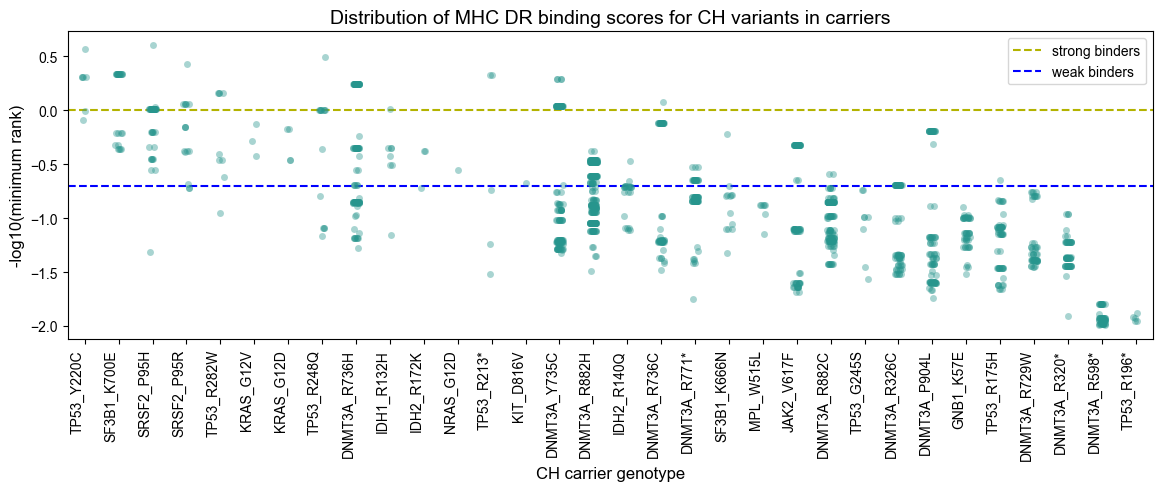

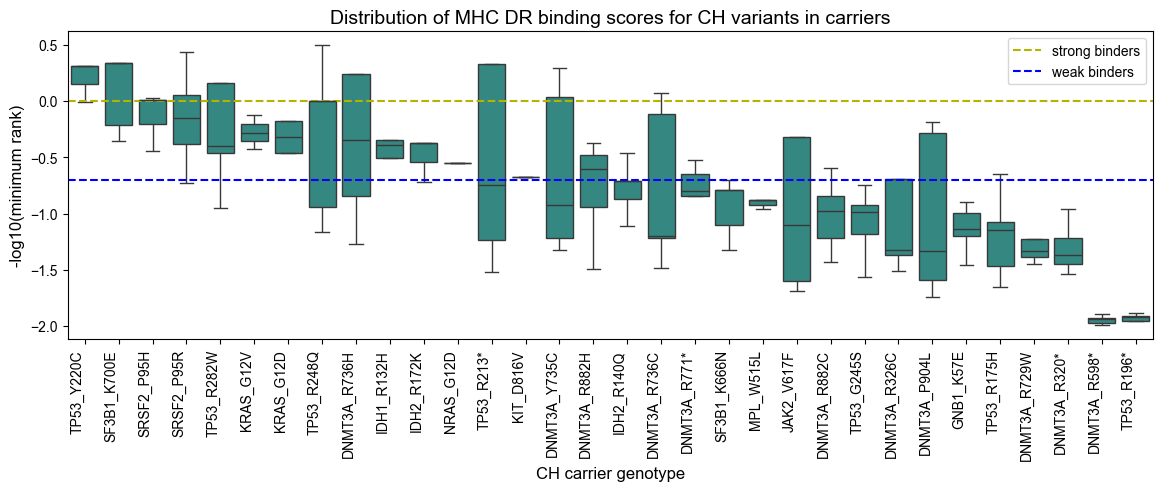

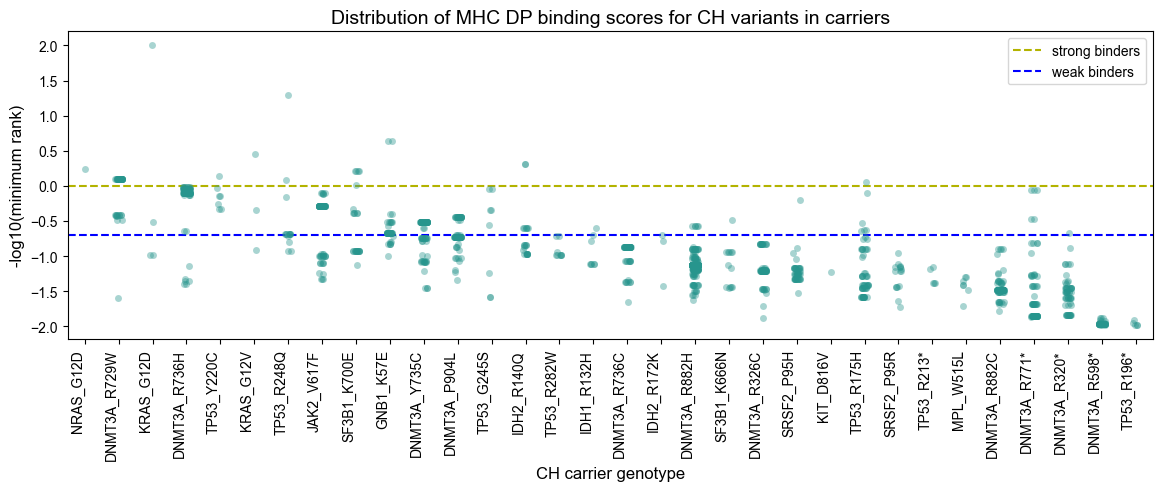

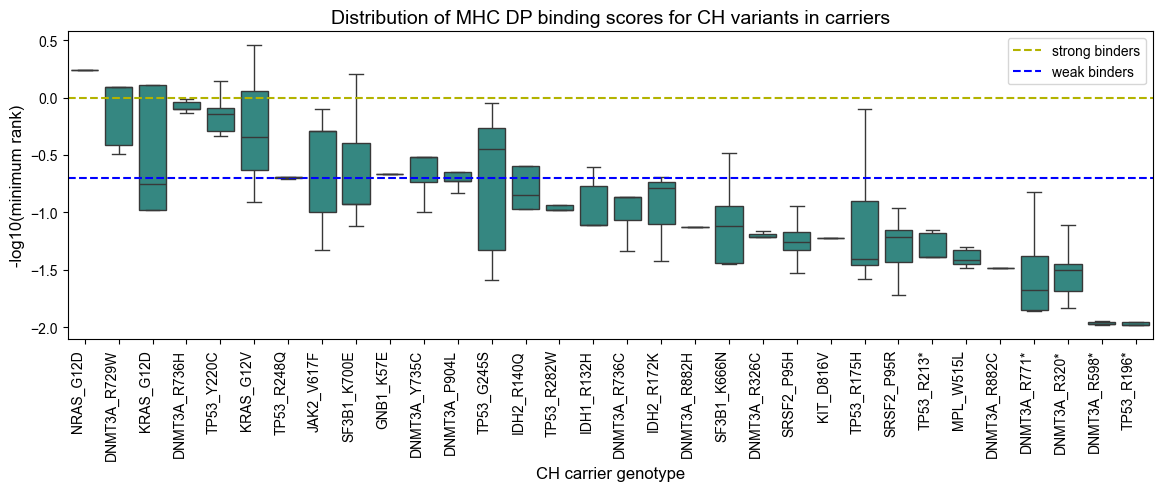

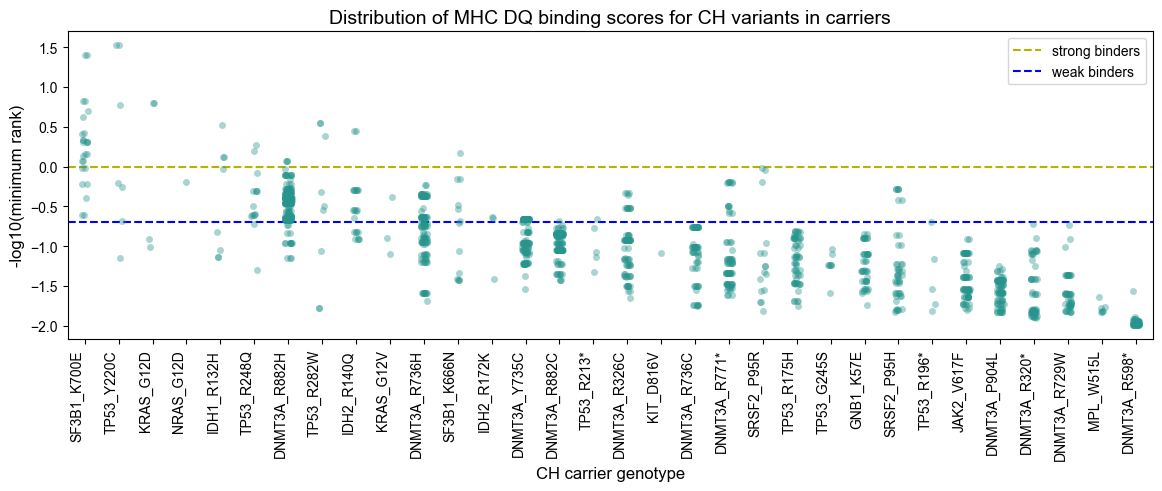

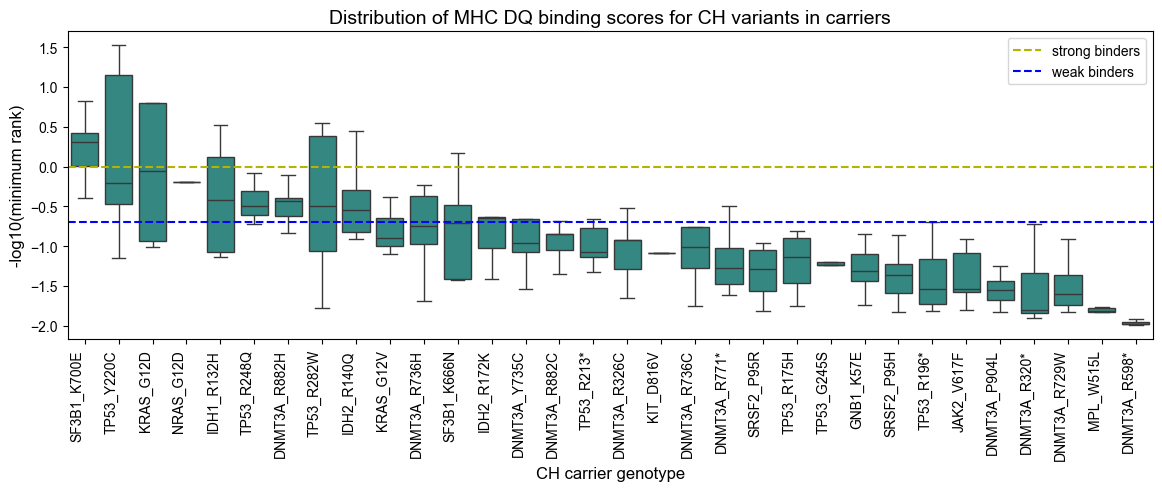

In [29]:

df_names = ['ch_hla_merge_sub_dr', 'ch_hla_merge_sub_dp', 'ch_hla_merge_sub_dq']
color = '#27958d' # this is the color we were using for NetMHC II scores, probably change once wifi is back 

for name in df_names:
    df = globals()[name]
    plot_distribution_of_scores(df, color)
    

In [30]:

# we can actually combine all these scores now 
ch_hla_merge_sub_all = pd.concat([ch_hla_merge_sub_dr, ch_hla_merge_sub_dp, ch_hla_merge_sub_dq], axis = 0)

# NB in the cell paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6482006/) they don't consider stuff separately
# I would say let's do the analysis for 3 allele classes separately for now and we can then just pick the best if we want to 

In [31]:

## Plot as individual histograms  

ch_hla_min = ch_hla_merge_sub_all[['gene_var', 'log_score', 'Person_ID', 'allele_type']]
ch_scores_melted = pd.melt(ch_hla_min, id_vars=['Person_ID', 'gene_var', 'allele_type'])

color = 'violet'

for var in ch_scores_melted['gene_var'].unique():
    
    df = ch_scores_melted[ch_scores_melted['variable'] == 'log_score'] # first, select log score 

    plt.figure(figsize=(6,3)) # set figure size
    sns.histplot(data=df[df['gene_var'] == f'{var}'], x=f'value', color=color)

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)
    plt.title(f'Binding scores for {var_name} in carriers', fontsize = 14)
    
    plt.xlim(-2, 3)

    plt.xlabel(f'-log10(minimum rank)', fontsize = 12)
    plt.ylabel('Number of CH cases', fontsize = 12)

    plt.axvline(x=-1 * np.log10(0.5), color='red', linestyle='--', label='Strong binders (< 0.5)')
    plt.axvline(x=-1 * np.log10(2), color='blue', linestyle='--', label='Weak binders (< 2)')

    plt.legend(fontsize = 8, loc = 'upper right')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{param}_histogram_score_distribution_{var}.pdf', bbox_inches='tight')
    plt.close()


# Find best scores for all CH variants examined

In [32]:

# define a function to find best scores for each examined variant for each CH case
def find_best_score(row, df, param, option=None):

    '''
    row = row of the dataframe you are applying the function to 
    df = df with predictions for each HLA-CH variant combination
    param = here you can choose %Rank_EL (scores) 
    option = can do normal scores of log (to select -log10(scores)) 
    '''

    hlas = row.index[1:-2][row[1:-2] >= 1] # select alleles which each Person (row) carries
    variants = df['gene_var'] # get out variants which are present 
    scores = {} # initialise empy dictionaries
    
    if param == "%Rank_EL":
        
        if option == 'log':
            for var in variants:
                
                if len(df.loc[df['gene_var'] == var, hlas].values[0]) == 0: # if HLA genotype has not been typed, you will get an empty list 
                    scores[f'log_score_{var}'] = None
                
                # we take the negative logaritm of the score (low score = tight binding > will be negative when log-transformed > will be high positive when multiplied by -1)
                else: # if we have some HLA alleles genotype and we have some values 
                    min_value = max(-1*np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
                    scores[f'log_score_{var}'] = min_value
            return pd.Series(scores)
        
        else:
            for var in variants:
                if len(df.loc[df['gene_var'] == var, hlas].values[0]) == 0:
                    scores[f'score_{var}'] = None
                else:
                    min_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
                    scores[f'score_{var}'] = min_value
            return pd.Series(scores)


In [33]:

# ADD ALL SCORES 

param = '%Rank_EL'

# DR
pred_sub_dr = pred_df_dr[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dr_wide = pd.pivot(pred_sub_dr, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dr_wide = pred_sub_dr_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dr = batch_gene_age_hla_dr.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dr = pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.isin(hla_ukbb_dr)] # HLA in the UKBB which I have predictions for 
hla_intersect_dr_list = hla_intersect_dr.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dr = pred_sub_dr_wide[hla_intersect_dr_list + pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dr = pred_sub_dr[pred_sub_dr['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dr = batch_gene_age_hla_dr[hla_intersect_dr_list + batch_gene_age_hla_dr.columns[batch_gene_age_hla_dr.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dr = pd.concat([batch_gene_age_hla_dr["Person_ID"], ch_hla_sub_dr], axis=1) # add CH cases 
ch_scores_all_var_dr = pd.concat([ch_hla_sub_dr, ch_hla_sub_dr.apply(find_best_score, df=pred_sub_dr, param=param, option='log', axis=1)], axis=1)

# merge scores with VAF and age
age_vaf_dr = batch_gene_age_hla_dr[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_all_var_merge_dr = pd.merge(ch_scores_all_var_dr, age_vaf_dr, on = ['Person_ID', 'gene_var'])


In [34]:

# DP
pred_sub_dp = pred_df_dpq[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dp = pred_sub_dp[~pred_sub_dp.duplicated()] # drop duplicates (I think we did not need the 736CH thing)
pred_sub_dp_wide = pd.pivot(pred_sub_dp, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dp_wide = pred_sub_dp_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dp = batch_gene_age_hla_dp.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dp = pred_sub_dp_wide.columns[pred_sub_dp_wide.columns.isin(hla_ukbb_dp)] # HLA in the UKBB which I have predictions for 
hla_intersect_dp_list = hla_intersect_dp.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dp = pred_sub_dp_wide[hla_intersect_dp_list + pred_sub_dp_wide.columns[pred_sub_dp_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dp = pred_sub_dp[pred_sub_dp['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dp = batch_gene_age_hla_dp[hla_intersect_dp_list + batch_gene_age_hla_dp.columns[batch_gene_age_hla_dp.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dp = pd.concat([batch_gene_age_hla_dp["Person_ID"], ch_hla_sub_dp], axis=1) # add CH cases 
ch_scores_all_var_dp = pd.concat([ch_hla_sub_dp, ch_hla_sub_dp.apply(find_best_score, df=pred_sub_dp, param=param, option='log', axis=1)], axis=1)

# merge scores with VAF and age
age_vaf_dp = batch_gene_age_hla_dp[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_all_var_merge_dp = pd.merge(ch_scores_all_var_dp, age_vaf_dp, on = ['Person_ID', 'gene_var'])

# DQ
pred_sub_dq = pred_df_dpq[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dq = pred_sub_dq[~pred_sub_dq.duplicated()]
pred_sub_dq_wide = pd.pivot(pred_sub_dq, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dq_wide = pred_sub_dq_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dq = batch_gene_age_hla_dq.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dq = pred_sub_dq_wide.columns[pred_sub_dq_wide.columns.isin(hla_ukbb_dq)] # HLA in the UKBB which I have predictions for 
hla_intersect_dq_list = hla_intersect_dq.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dq = pred_sub_dq_wide[hla_intersect_dq_list + pred_sub_dq_wide.columns[pred_sub_dq_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dq = pred_sub_dq[pred_sub_dq['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dq = batch_gene_age_hla_dq[hla_intersect_dq_list + batch_gene_age_hla_dq.columns[batch_gene_age_hla_dq.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dq = pd.concat([batch_gene_age_hla_dq["Person_ID"], ch_hla_sub_dq], axis=1) # add CH cases 
ch_scores_all_var_dq = pd.concat([ch_hla_sub_dq, ch_hla_sub_dq.apply(find_best_score, df=pred_sub_dq, param=param, option='log', axis=1)], axis=1)

# merge scores with VAF and age
age_vaf_dq = batch_gene_age_hla_dq[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_all_var_merge_dq = pd.merge(ch_scores_all_var_dq, age_vaf_dq, on = ['Person_ID', 'gene_var'])


In [35]:

# prepare the dataset with genetic variants and scores for each person
# gene var indicates the CH variant CARRIED by the person
# variable is the name of the genetic variant for which we have the score in the value column

# select score columns you are interested in 
score_columns_dr = [col for col in ch_hla_all_var_merge_dr.columns if col.startswith('log_score_')]
selected_columns_dr = score_columns_dr + ['Person_ID', 'gene_var']
ch_scores_subset_dr = ch_scores_all_var_dr[selected_columns_dr] 
ch_scores_melted_dr = pd.melt(ch_scores_subset_dr, id_vars=['Person_ID', 'gene_var'])
ch_scores_melted_dr['allele_type'] = 'DR'

score_columns_dp = [col for col in ch_hla_all_var_merge_dp.columns if col.startswith('log_score_')]
selected_columns_dp = score_columns_dp + ['Person_ID', 'gene_var']
ch_scores_subset_dp = ch_scores_all_var_dp[selected_columns_dp] 
ch_scores_melted_dp = pd.melt(ch_scores_subset_dp, id_vars=['Person_ID', 'gene_var'])
ch_scores_melted_dp['allele_type'] = 'DP'

score_columns_dq = [col for col in ch_hla_all_var_merge_dq.columns if col.startswith('log_score_')]
selected_columns_dq = score_columns_dq + ['Person_ID', 'gene_var']
ch_scores_subset_dq = ch_scores_all_var_dq[selected_columns_dq] 
ch_scores_melted_dq = pd.melt(ch_scores_subset_dq, id_vars=['Person_ID', 'gene_var'])
ch_scores_melted_dq['allele_type'] = 'DQ'

ch_scores_melted_all = pd.concat([ch_scores_melted_dr, ch_scores_melted_dp, ch_scores_melted_dq], axis = 0)
ch_scores_melted_all

,Person_ID,gene_var,variable,value,allele_type
0,2100538,TP53_R213*,log_score_DNMT3A_P904L,-1.601625,DR
1,1641209,TP53_R213*,log_score_DNMT3A_P904L,-1.160168,DR
2,1471938,TP53_R213*,log_score_DNMT3A_P904L,-0.187521,DR
3,1482881,TP53_R213*,log_score_DNMT3A_P904L,-0.187521,DR
4,1946555,TP53_R213*,log_score_DNMT3A_P904L,-1.174060,DR
...,...,...,...,...,...
66172,1619263,IDH2_R172K,log_score_TP53_Y220C,-0.583199,DQ
66173,1456018,IDH2_R172K,log_score_TP53_Y220C,-0.367356,DQ
66174,2045629,IDH2_R172K,log_score_TP53_Y220C,1.698970,DQ
66175,1740102,NRAS_G12D,log_score_TP53_Y220C,0.920819,DQ


In [36]:

# plot score distribution (histogram)

# plot distribution of variant scores for each variant 
for var in ch_scores_melted_all.gene_var.unique():
    
    plt.figure(figsize=(6,3)) # set figure size
    sns.histplot(data=ch_scores_melted_all[ch_scores_melted_all['variable'] == f'log_score_{var}_ch'], x=f'value', color='maroon')

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)
    plt.title(f'Binding scores for {var_name}', fontsize = 14)
    
    plt.xlim(-2, 3)
    plt.xlabel(f'-log10(minimum rank)', fontsize = 12)
    plt.ylabel('Number of CH cases', fontsize = 12)

    plt.axvline(x=-1 * np.log10(1), color='red', linestyle='--', label='Strong binders (< 1)')
    plt.axvline(x=-1 * np.log10(5), color='black', linestyle='--', label='Weak binders (< 5)')

    plt.legend(fontsize = 11, loc = 'upper right')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{param}_histogram_score_distribution_{var}.pdf', bbox_inches='tight')
    plt.close()

# plot distribution of variant scores (splitting by status: carrier vs non-carrier)
for var in ch_scores_melted.gene_var.unique():   
    
    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    data=ch_scores_melted_all[ch_scores_melted_all['variable'] == f'log_score_{var}_ch']
    data_carrier = data[data['gene_var'] == var]
    data_noncarrier = data[data['gene_var'] != var]

    plt.figure(figsize=(6,3)) # set figure size

    sns.histplot(data=data_carrier, x=f'value', color='darkorange', label = f'{var_name}+')
    sns.histplot(data=data_noncarrier, x=f'value', color='lightblue', alpha = 0.5, label = f'{var_name}-')

    plt.title(f'Binding scores for {var_name}', fontsize = 14)
    
    plt.xlim(-2, 3)
    plt.xlabel(f'-log10(minimum rank)', fontsize = 12)
    plt.ylabel('Number of CH cases', fontsize = 12)

    plt.axvline(x=-1 * np.log10(1), color='red', linestyle='--', label='Strong binders (< 1)')
    plt.axvline(x=-1 * np.log10(5), color='black', linestyle='--', label='Weak binders (< 5)')

    plt.legend(fontsize = 11, loc = 'upper right')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{param}_histogram_score_distribution_{var}.pdf', bbox_inches='tight')
    plt.close()


# Compare variant scores between carriers and non-carriers 

In [110]:

# note: this is comparison between carriers of variant X and other CH carriers 
from scipy.stats import mannwhitneyu

# PLOT1: is there a difference in variant scores in carriers vs non-carriers?
def plot_carries_vs_non_score_diff(df):
    
    score = '-log10(%Rank EL)'
    score_title = '-log10(%Rank EL)'
    colors = ['#d51b21', '#1b7ed5']
    xaxis_scores = df.variable
    plot_labels = [category[10:] for category in xaxis_scores]
    
    df['median_score'] = df[df['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
    df_sort = df.sort_values(by='median_score', ascending = False)
    order = df_sort.gene_var.unique()
    
    # plot 1 (boxplot)
    plt.figure(figsize = (20,5))
    p = sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, showfliers = False, palette = colors, order = order)
    plt.title(f'{score_title}', fontsize = 10)
    plt.ylim(-2.5, 3)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant.pdf', bbox_inches='tight')

    # plot 2 (stripplot)
    plt.figure(figsize = (20,5))
    p = sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, jitter = True, dodge = True, size = 2, palette = colors, order = order, alpha = 0.2)
    plt.title(f'{score_title}', fontsize = 10)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.ylim(-2.5, 3)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', markerscale=6, loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    
    # okay we also want to add a line to indicate where the mean is for each category + hue
    # btw I am doing mean but can do median too - tho doing both on one plots seems like too much?

    for i, category in enumerate(order):
        
        median_carrier = df[(df['variable'] == f'log_score_{category}') & (df['is_variant_present'] == True)].value.median()
        median_noncarrier = df[(df['variable'] == f'log_score_{category}') & (df['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#d51b21')
        plt.text(i + 0.5, median_noncarrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#1b7ed5')

    # okay no we want to add the kruskall-wallis test to this to see if there are any differences between variant scores 
    for i, category in enumerate(order):
        category_data = df[df['variable'] == f'log_score_{category}']
        max_value = category_data['value'].max()
        groups = [group['value'].values for name, group in category_data.groupby('is_variant_present')]
        statistic, p_value = mannwhitneyu(*groups)
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant.pdf', bbox_inches='tight')

    # jitter but without all the fancy add-ons just in case 
    plt.figure(figsize = (20,5))
    p = sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df, jitter = True, dodge = True, size = 2, palette = colors, order = order, alpha = 0.2)
    plt.xlabel('CH variant', fontsize = 18)
    plt.ylabel(f'{score_title}', fontsize = 18)
    plt.ylim(-2.5, 3)
    plt.xticks(rotation = 90, fontsize = 14)   
    plt.yticks(fontsize = 14)
    plt.legend(title = 'Carrier status', markerscale=6, loc = 'upper right', fontsize = 14, title_fontsize = 16)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    
    # still add median but no statistical testing stuff 
    for i, category in enumerate(order):
            
            median_carrier = df[(df['variable'] == f'log_score_{category}') & (df['is_variant_present'] == True)].value.median()
            median_noncarrier = df[(df['variable'] == f'log_score_{category}') & (df['is_variant_present'] == False)].value.median()

            # Plot text for each hue group
            plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#d51b21')
            plt.text(i + 0.5, median_noncarrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#1b7ed5')

    # okay no we want to add the kruskall-wallis test to this to see if there are any differences between variant scores 
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_no_pvalue.pdf', bbox_inches='tight')


In [100]:

# first, add column to indicate variant carried
def var_carried(row):
    substring_col1 = row['gene_var']  # Extract substring from col1 starting from 5th character
    substring_col2 = row['variable'][10:]  # Extract substring from col2 starting from 5th character
    return substring_col1 == substring_col2


In [ ]:

# Check if substrings are equal ignoring case
ch_scores_melted_all['is_variant_present'] = ch_scores_melted_all.apply(var_carried, axis=1)
ch_scores_melted_all['is_variant_present2'] = ch_scores_melted_all['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})
cat_dtype = pd.CategoricalDtype(categories=['Carrier', 'Non-carrier'], ordered=True)
ch_scores_melted_all['is_variant_present2'] = ch_scores_melted_all['is_variant_present2'].astype(cat_dtype)

ch_scores_melted_all.reset_index(drop=True, inplace=True)

In [126]:
# remove variants which are not identified in the dataset 
var_examined = ch_scores_melted_all.variable[10:].unique().tolist()
var_present = ch_scores_melted_all.gene_var.unique().tolist()
var_allowed = [f'log_score_{var}' for var in var_present]
ch_scores_melted_all = ch_scores_melted_all[ch_scores_melted_all['variable'].isin(var_allowed)]

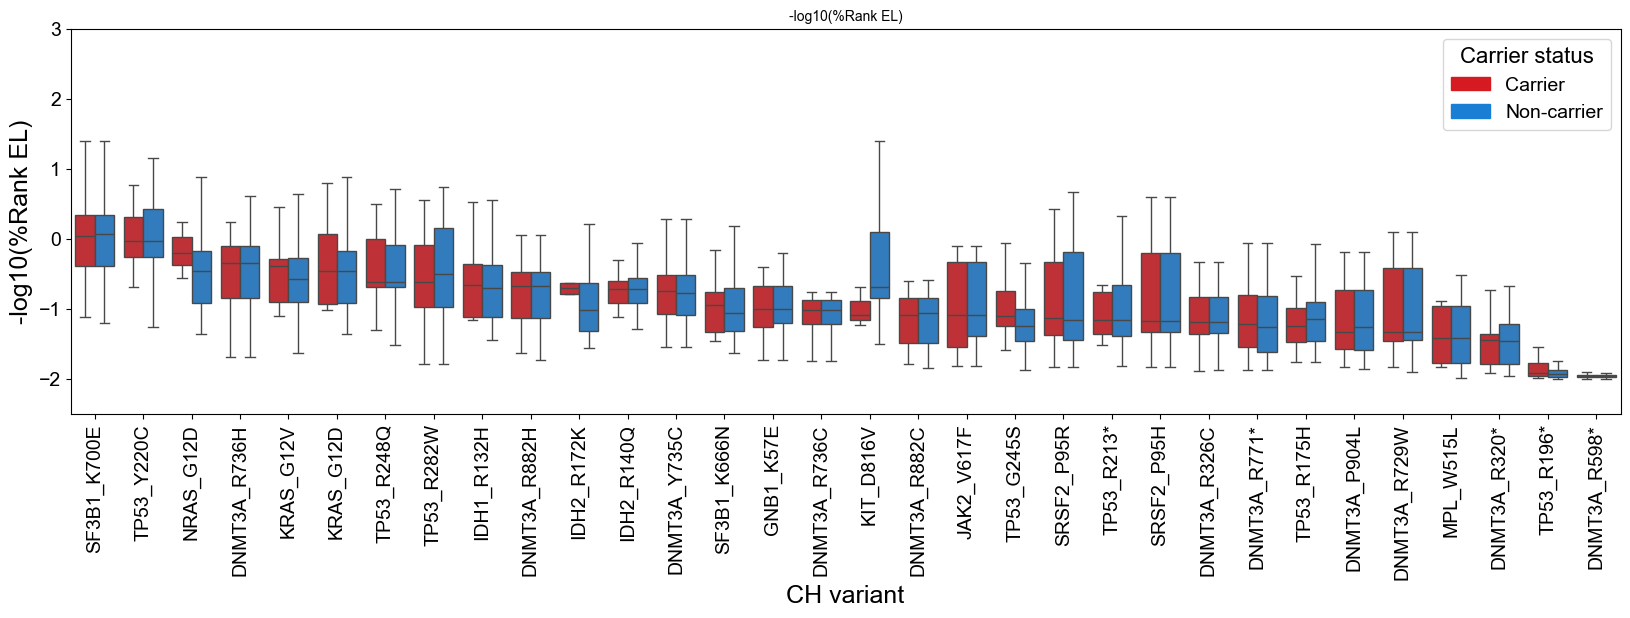

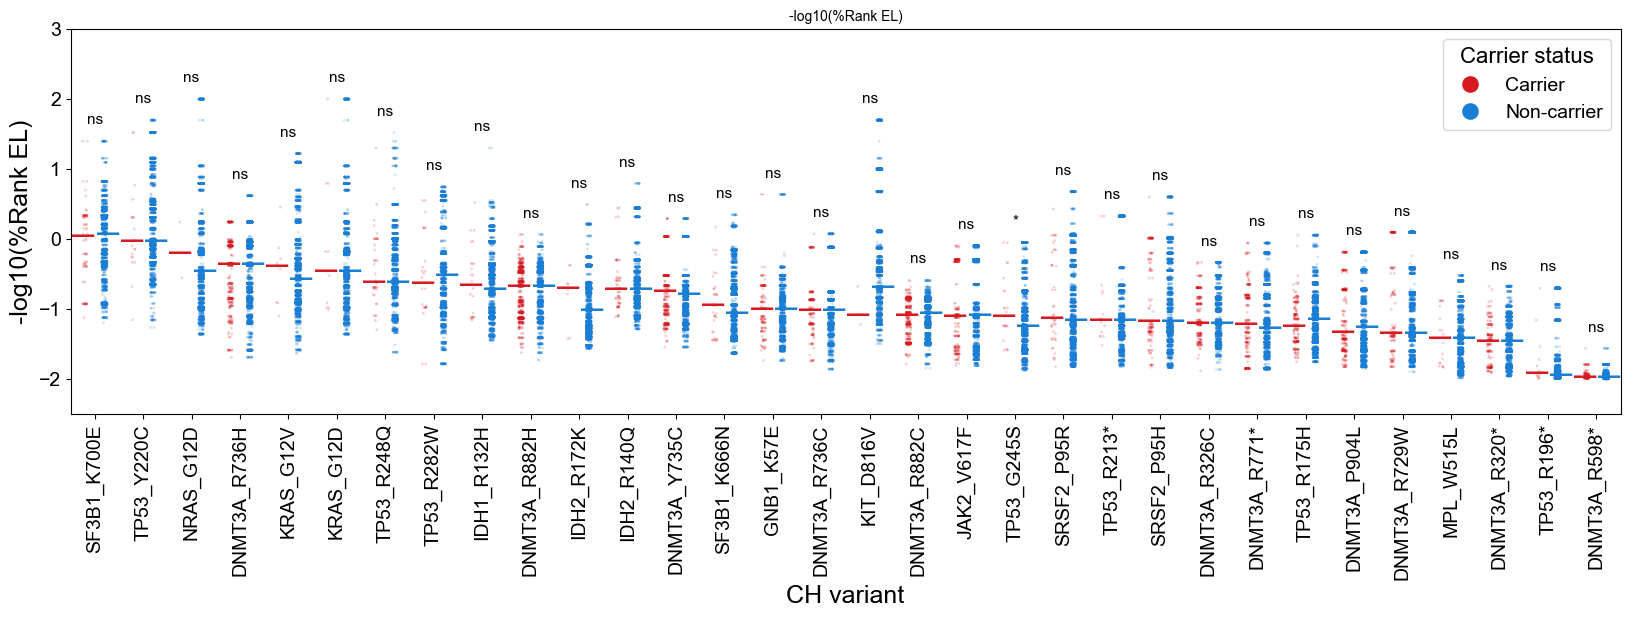

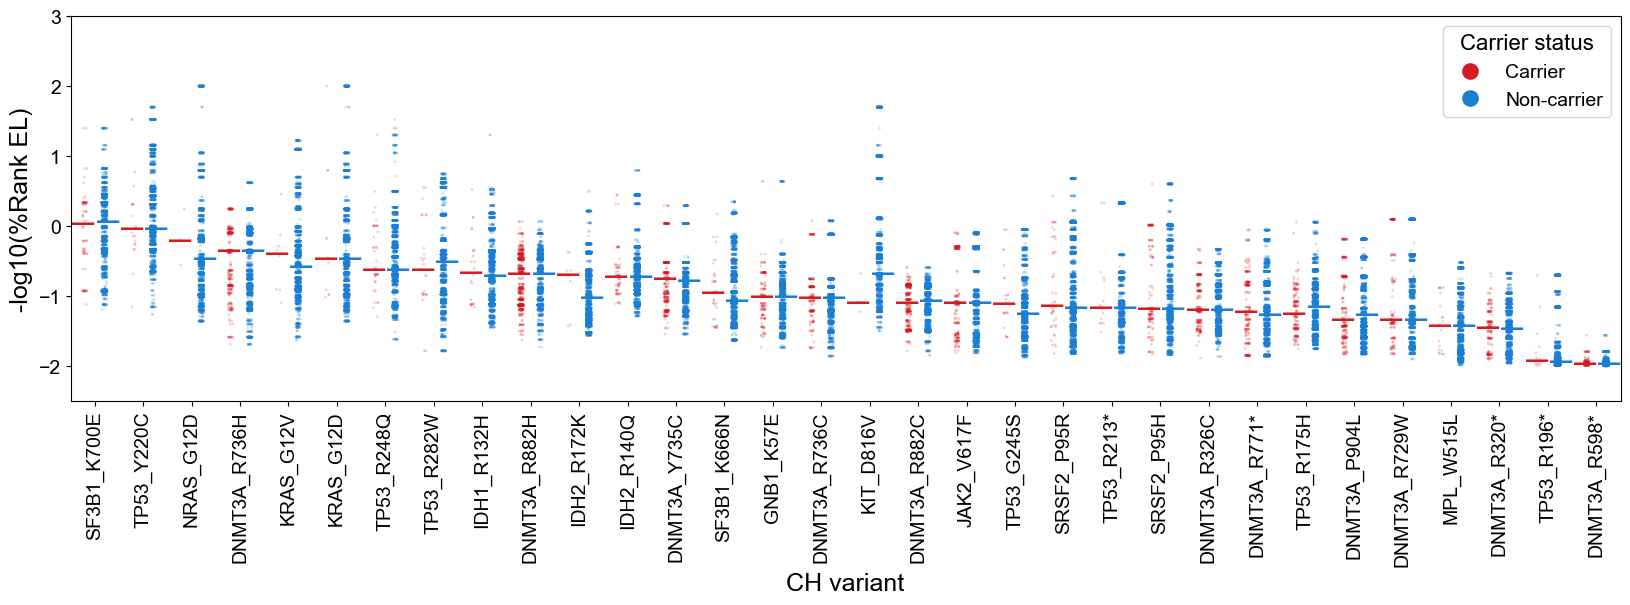

In [127]:

# plot
plot_carries_vs_non_score_diff(ch_scores_melted_all)


In [129]:

# separate stop codons (not immunogenic) and substitutions (immunogenic)

# PLOT1: is there a difference in variant scores in carriers vs non-carriers?

def plot_carries_vs_non_score_diff_facets(df):
    
    score = '-log10(%Rank EL)'
    score_title = '-log10(%Rank EL)'
    colors = ['#d51b21', '#1b7ed5']
    
    # split by mutation order
    df_stop = df[df['mutation_type'] == 'nonsense']
    df_sub = df[df['mutation_type'] == 'missense']
        
    # STOP CODONS (NONSENSE)
    df_stop['median_score'] = df_stop[df_stop['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_stop_sort = df_stop.sort_values(by='median_score', ascending = False)
    df_stop_sort['gene_var'] = df_stop_sort['gene_var'].astype(str)
    order = df_stop_sort.variable.unique()
    
    xaxis_scores = df_stop_sort.variable
    plot_labels = [category[10:] for category in xaxis_scores]
    
    # JITTER
    plt.figure(figsize = (5,5))
    sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_stop_sort, jitter = True, dodge = True, size = 2, palette = colors, alpha = 0.4)
    plt.title(f'Nonsense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 11)
    plt.yticks(fontsize = 11)
    
    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
            
        median_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.median()
        median_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=20, fontweight='bold', color = '#d51b21')
        plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=20, fontweight='bold', color = '#1b7ed5')

        # add results of a statistical test (Mann-Whitney)
        max_value = df_stop_sort[df_stop_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', markerscale = 4, loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend() 
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_stop.pdf', bbox_inches='tight')

    # BOXPLOT

    plt.figure(figsize = (5,5))
    sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_stop_sort, showfliers = False, palette = colors)
    plt.title(f'Nonsense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  

    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):

        # add results of a statistical test (Mann-Whitney)
        max_value = df_stop_sort[df_stop_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_stop_sort[(df_stop_sort['variable'] == f'{category}') & (df_stop_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.1+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_stop.pdf', bbox_inches='tight')
  
    # SUBSTITUTIONS (MISSENSE)
    
    df_sub['median_score'] = df_sub[df_sub['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_sub_sort = df_sub.sort_values(by='median_score', ascending = False)
    order = df_sub_sort.variable.unique()

    xaxis_scores = df_sub_sort.variable
    plot_labels = [category[10:] for category in xaxis_scores]
    
    # JITTERPLOT 
    
    plt.figure(figsize = (15,5))
    sns.stripplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_sub_sort, jitter = True, dodge = True, size = 2, palette = colors, alpha = 0.4)
    plt.title(f'Missense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)

    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
        
        median_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.median()
        median_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.median()

        # Plot text for each hue group
        plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=13, fontweight='bold', color = '#d51b21')
        plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=13, fontweight='bold', color = '#1b7ed5')

        # add results of a statistical test (Mann-Whitney)
        max_value = df_sub_sort[df_sub_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  
    plt.legend(title = 'Carrier status', markerscale = 6, loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_sub.pdf', bbox_inches='tight')
  
    # BOXPLOT

    plt.figure(figsize = (15,5))
    sns.boxplot(y='value', x=plot_labels, hue='is_variant_present2', data=df_sub_sort, showfliers = False, palette = colors)
    plt.title(f'Missense mutations: {score_title}')
    plt.xlabel('CH variant', fontsize = 14)
    plt.ylabel(f'{score_title}', fontsize = 14)
    plt.ylim(-2.5, 3.5)
    plt.xticks(rotation=90, fontsize = 12)  
    plt.yticks(fontsize = 12)  
        
    # add median value and p value from Mann Whitney 
    for i, category in enumerate(order):
        
        # add results of a statistical test (Mann-Whitney)
        max_value = df_sub_sort[df_sub_sort['variable'] == f'{category}']['value'].max()
        value_carrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == True)].value.tolist()
        value_noncarrier = df_sub_sort[(df_sub_sort['variable'] == f'{category}') & (df_sub_sort['is_variant_present'] == False)].value.tolist()

        statistic, p_value = mannwhitneyu(value_carrier, value_noncarrier) 
        significance = ''
        if p_value > 0.05:
            significance = 'ns'
        elif p_value < 0.01:
            significance = '**'
        else:
            significance = '*'
        plt.text(i, 0.1+max_value, significance, ha='center', va='bottom', fontsize=11)

    plt.legend(title = 'Carrier status', loc = 'upper right', fontsize = 11, title_fontsize = 12)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_sub.pdf', bbox_inches='tight')
  

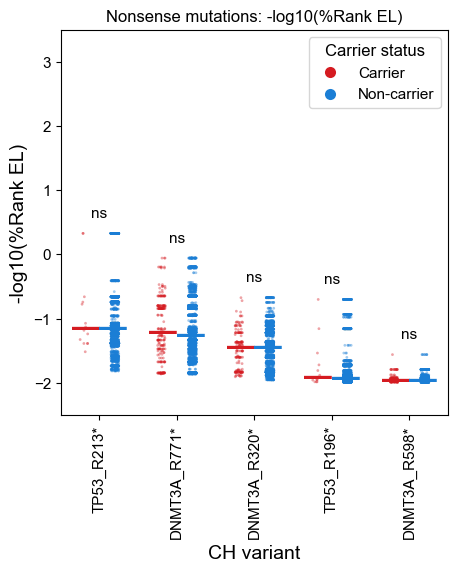

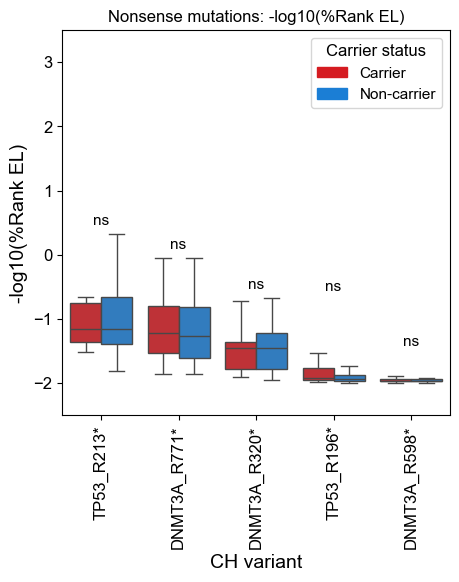

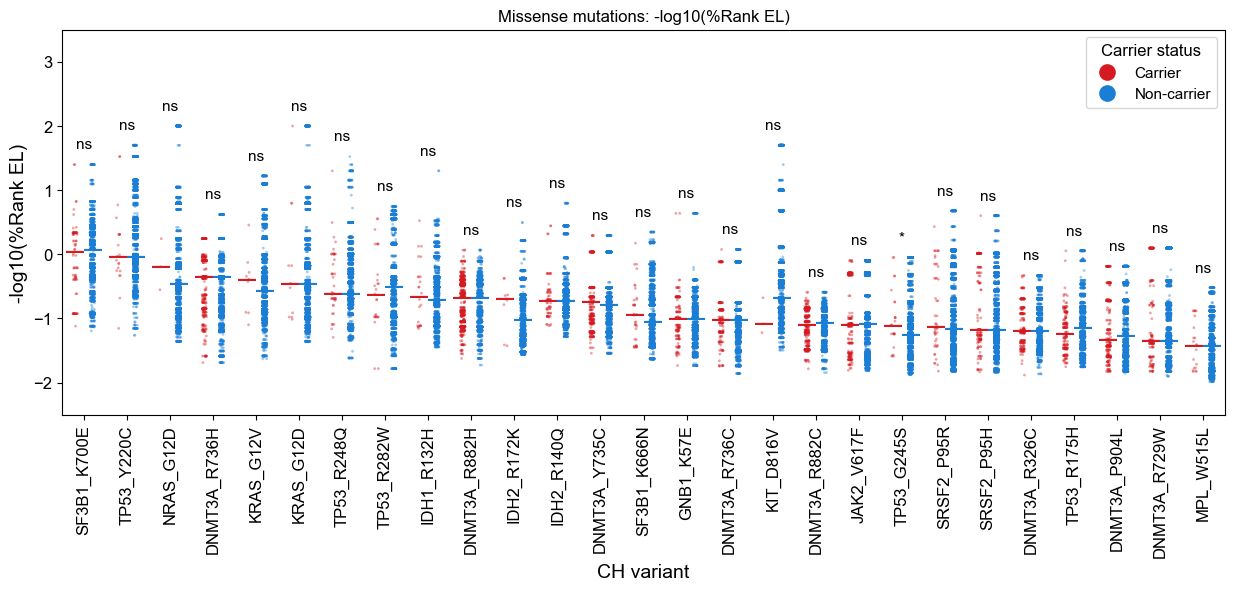

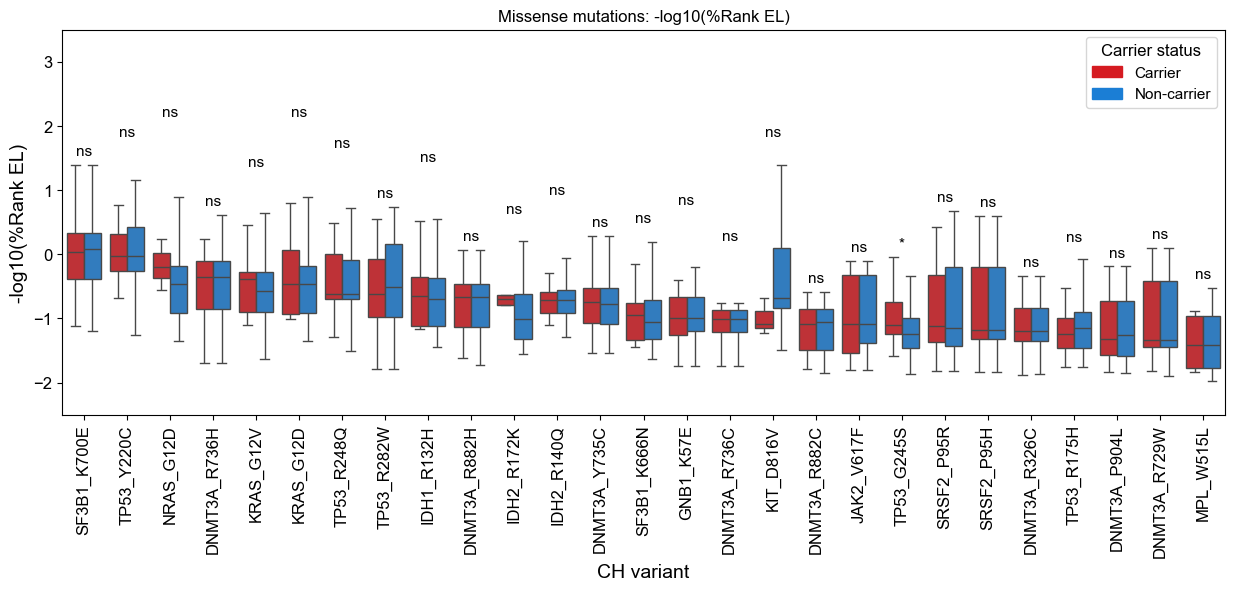

In [130]:

# add column with mutation type (non-sense or mis-sense)
ch_scores_melted_all['mutation_type'] = ch_scores_melted_all['variable'].apply(lambda x: 'nonsense' if x[-1] == '*' else 'missense') # non-sense: stop codon, mis-sense: substitution

# plot with facets
plot_carries_vs_non_score_diff_facets(ch_scores_melted_all)

In [133]:
    
# aggregate

def plot_carrier_vs_non_aggregate(df):
    
    score = '-log10(%Rank_EL)'
    score_title = '-log10(%Rank_EL)'
    colors = ['#f00071', '#0497ed']
    df['is_variant_present2'] = df['is_variant_present'].map({True: 'Carrier', False: 'Non-carrier'})

    # split by mutation order
    df_stop = df[df['mutation_type'] == 'nonsense']
    df_sub = df[df['mutation_type'] == 'missense']

    colors = ['#d51b21', '#1b7ed5']

    # JITTER

    # Non-sense (STOP codons)
    df_stop['median_score'] = df_stop[df_stop['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_stop_sort = df_stop.sort_values(by='median_score', ascending = False)
    order = df_stop_sort.variable.unique()

    plt.figure(figsize = (4,4))
    sns.stripplot(y='value', x='is_variant_present2', data=df_stop_sort, jitter = True, size = 3, palette = colors, alpha = 0.2)
    plt.title(f'Nonsense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11)  

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    median_carrier = df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'].median()
    median_noncarrier = df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'].median()
    plt.text(0, median_carrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#d51b21')
    plt.text(1, median_noncarrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#1b7ed5')


    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_all_agg_stop.pdf', bbox_inches='tight')

    # Mis-sense (Substitutions)
    colors = ['#d51b21', '#1b7ed5']

    df_sub['median_score'] = df_sub[df_sub['is_variant_present']==True].groupby('variable')['value'].transform('median')
    df_sub_sort = df_sub.sort_values(by='median_score', ascending = False)
    order = df_sub_sort.variable.unique()

    plt.figure(figsize = (4,4))
    sns.stripplot(y='value', x='is_variant_present2', data=df_sub_sort, jitter = True, size = 3, palette = colors, alpha = 0.2)
    plt.title(f'Missense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11)  

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    # add median values
    median_carrier = df_sub[df_sub['is_variant_present2'] == 'Carrier']['value'].median()
    median_noncarrier = df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'].median()
    plt.text(0, median_carrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#d51b21')
    plt.text(1, median_noncarrier, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#1b7ed5')

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_chvariant_all_agg_sub.pdf', bbox_inches='tight')

    # BOXPLOT

    # Non-sense (STOP codons)
    plt.figure(figsize = (4,4))
    sns.boxplot(y='value', x='is_variant_present2',  data=df_stop, showfliers = False, palette = colors)
    plt.title(f'Nonsense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11) 

    statistic, p_value = mannwhitneyu(df_stop[df_stop['is_variant_present2'] == 'Carrier']['value'], 
            df_stop[df_stop['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_all_agg_stop.pdf', bbox_inches='tight')
  
    # Mis-sense (Substitution)
    plt.figure(figsize = (4,4))
    sns.boxplot(y='value', x='is_variant_present2',  data=df_sub, showfliers = False, palette = colors)
    plt.title(f'Missense mutations:\n {score_title}', fontsize = 14)
    plt.xlabel('Genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-3, 4)
    plt.xticks(fontsize = 11) 

    statistic, p_value = mannwhitneyu(df_sub[df_sub['is_variant_present2'] == 'Carrier']['value'], 
            df_sub[df_sub['is_variant_present2'] == 'Non-carrier']['value'])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_chvariant_all_agg_sub.pdf', bbox_inches='tight')
  

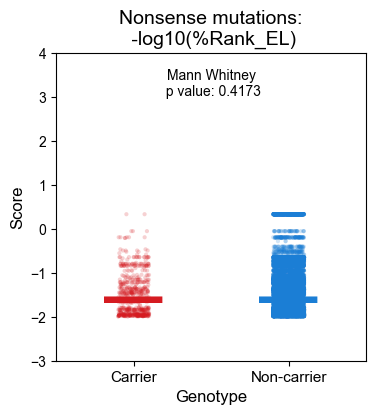

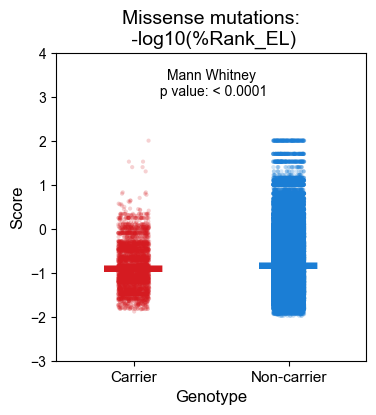

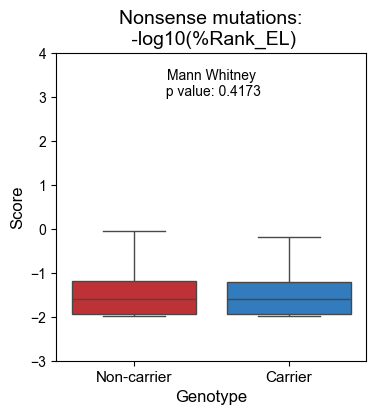

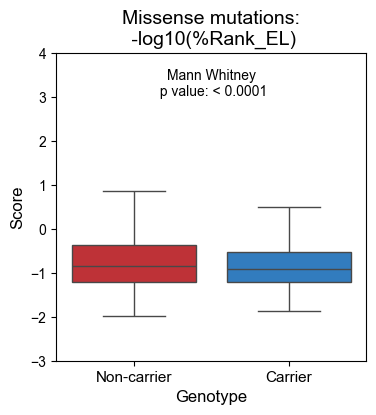

In [134]:

# plot with facets
plot_carrier_vs_non_aggregate(ch_scores_melted_all)
    

# Compare score of variant carried to scores of other variants 

In [151]:

# PLOT2: Is the score of the variant in people who carry it different from scores of other variants?
# for this plot, order the df by score for present variants

def plot_scores_variant_carried_vs_other(df):

    score = '-log10(%Rank_EL)'
    score_title = '-log10(%Rank_EL)'
    colors = ['#911216', '#f1979a'] # I want similar colors but I guess not identical ones?

    # specify format of x axis labels
    xaxis_scores = df.variable
    plot_labels = [category[10:] for category in xaxis_scores]
    
    df['median_score'] = df[df['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
    df_sort = df.sort_values(by='median_score', ascending = False)
    order = df_sort.gene_var.unique()
    hue_order = ['Variant carried', 'Other variants']

    # plot 1: boxplot
    plt.figure(figsize = (16,4))
    sns.boxplot(x="gene_var", y="value", hue = 'is_variant_present3', data=df, showfliers = False, order = order, palette = colors, hue_order = hue_order)
    plt.ylim(-2.5, 3)
    plt.title(f'{score_title}', fontsize = 14)
    plt.xlabel('CH carrier genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(rotation = 90, fontsize = 11)
    plt.yticks(fontsize = 11)
    plt.legend(title='Variant in the CH case', loc = 'upper right', fontsize = 11, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_genotype.pdf', bbox_inches='tight')

    # plot 2: stripplot (side by side, I scrapped overlay because it looks terrible)
    plt.figure(figsize = (16,4))
    sns.stripplot(x="gene_var", y="value", hue = 'is_variant_present3', data=df, dodge=True, size = 4, order = order, palette = colors, alpha = 0.3, hue_order = hue_order)
    plt.ylim(-2.5, 3)
    plt.title(f'{score_title}')
    plt.xlabel('CH carrier genotype', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(rotation = 90, fontsize = 11)
    plt.yticks(fontsize = 11)
    plt.legend(title='Variant in the CH case', labels=['Variant carried', 'Other variants'], markerscale=2, loc = 'upper right', fontsize = 11, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)

    for i, category in enumerate(order):

        median_present = df[(df['gene_var'] == category) & (df['is_variant_present'] == True)]['value'].median()
        median_absent = df[(df['gene_var'] == category) & (df['is_variant_present'] == False)]['value'].median()
        plt.text(i, median_present, '—', ha='right', va='center', fontsize=13, fontweight='bold', color = '#911216')
        plt.text(i, median_absent, '—', ha='left', va='center', fontsize=13, fontweight='bold', color = '#f1979a')
        
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_{score}_jitter_correct_genotype_sidebyside.pdf', bbox_inches='tight')

In [152]:

# set the correct order of plotting levels
ch_scores_melted_all['is_variant_present3'] = ch_scores_melted_all['is_variant_present'].map({True: 'Variant carried', False: 'Other variants'})
cat_dtype = pd.CategoricalDtype(categories=['Variant carried', 'Other variants'], ordered=True)
ch_scores_melted_all['is_variant_present3'] = ch_scores_melted_all['is_variant_present3'].astype(cat_dtype)


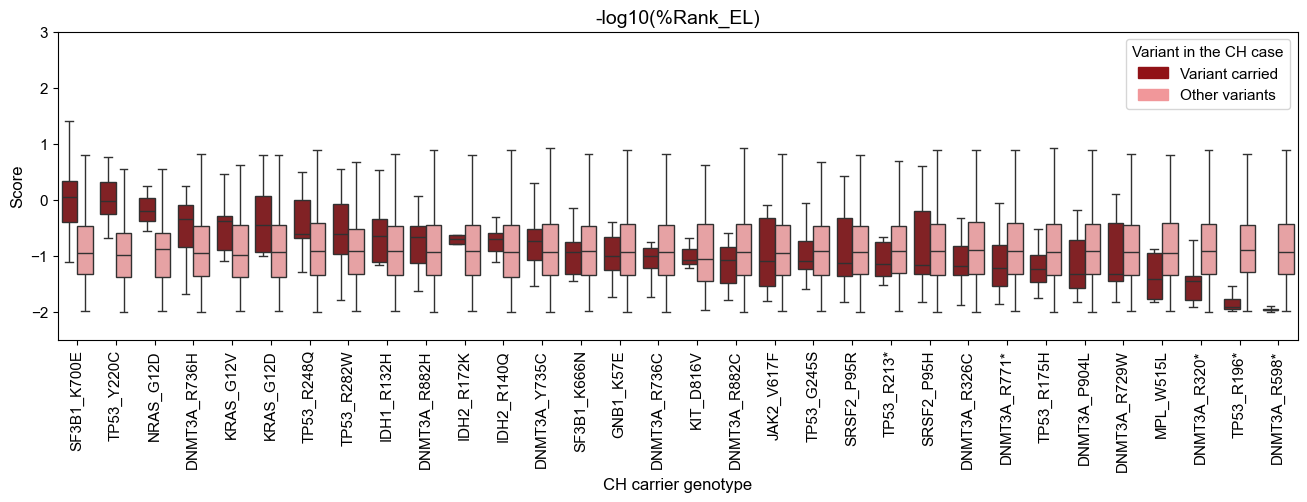

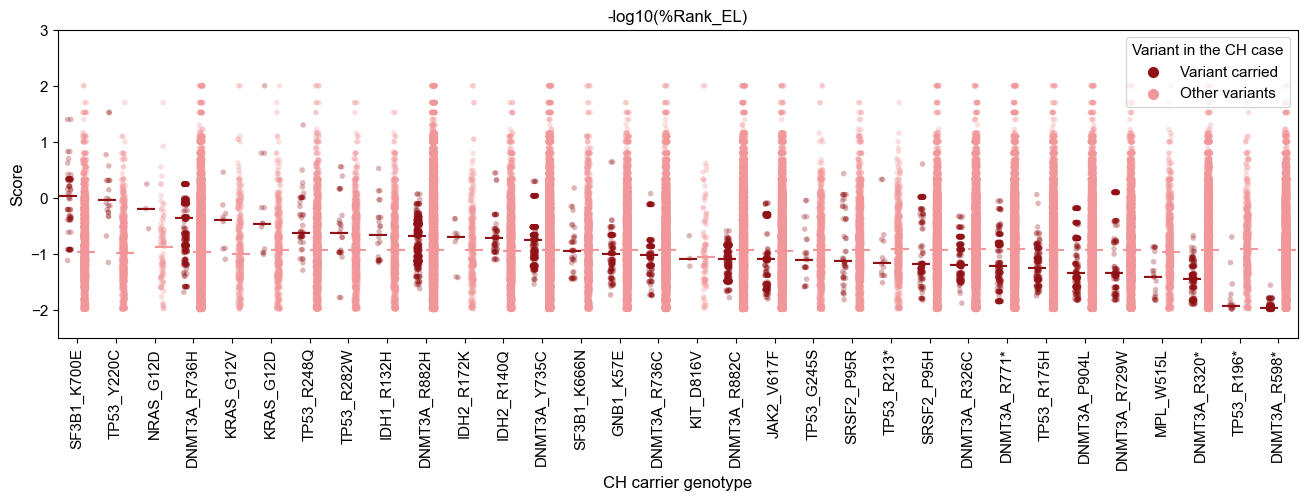

In [153]:

plot_scores_variant_carried_vs_other(ch_scores_melted_all)

# Present vs absent variants 

In [157]:

# plot separately for each variant 

def plot_observed_vs_unobserved(data, x, y, xlabel, name, var, score, score_title):
    
    colors = ['#911216', '#f1979a']

    # BOXPLOT
    plt.figure(figsize=(4,4)) 
    p = sns.boxplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, showfliers = False)
    plt.title(f'{var}: {score_title}', fontsize = 14)
    plt.xlabel('Variant', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(-2.5, 3)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Present'][y], 
        data[data[x] == 'Absent'][y])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_boxplot.pdf', bbox_inches='tight')

    # JITTER
    plt.figure(figsize=(4,4)) 
    p = sns.stripplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, dodge = False, size = 4, alpha = 0.3)
    plt.title(f'{var}: {score_title}', fontsize = 14)
    plt.xlabel('Variant', fontsize = 12)
    plt.ylabel('Score', fontsize = 12)
    plt.ylim(-2.5, 3)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Present'][y], 
        data[data[x] == 'Absent'][y])
    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.93), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    # add annotation to indicate median
    median_present = data[data[x] == 'Present'][y].median()
    median_absent = data[data[x] == 'Present'][y].median()
    plt.text(0, median_present, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#911216')
    plt.text(1, median_absent, '—', ha='center', va='center', fontsize=42, fontweight='bold', color = '#f1979a')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_boxplot.pdf', bbox_inches='tight')


# define function to plot across dataframes 
def observed_unobserved(df):

    score = '-log10(%Rank_EL)'
    score_title = '-log10(%Rank_EL)'

    variants = []

    for var in variants:
        
        var_name = var.split('_')[0:2]
        var_name = ' '.join(var_name)

        data = df[df['variable'] == f'log_score_{var}'] # select entries with the variant 
        plot_observed_vs_unobserved(data, 'is_variant_present3', 'value', 'Mutation observed', 'score', var, var_name, score, score_title)

    # plot all variants together
    plot_observed_vs_unobserved(df, 'is_variant_present4', 'value', 'Mutation observed', 'all_32variants', 'All CH cases', score, score_title)
    

In [159]:

ch_scores_melted_all['is_variant_present4'] = ch_scores_melted_all['is_variant_present'].map({True: 'Present', False: 'Absent'})
cat_dtype = pd.CategoricalDtype(categories=['Present', 'Absent'], ordered=True)
ch_scores_melted_all['is_variant_present4'] = ch_scores_melted_all['is_variant_present4'].astype(cat_dtype)
    

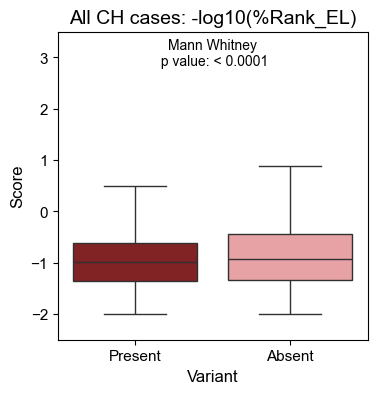

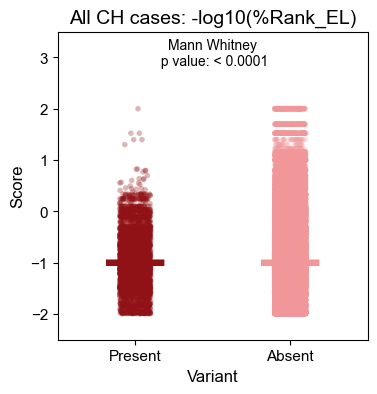

In [160]:
observed_unobserved(ch_scores_melted_all)

# VAF distribution comparison based on presentation

In [194]:

# Okay, first, we need to get a score column so that will be a log score which matches the gene var someone has 
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

# split into a desired number of groups
def split_into_equal_groups(df, num_groups):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    df['rank'] = df['value'].rank(method='first', ascending=False)
    
    # assign groups based on rank 

    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    df_sort = df.sort_values(by = 'rank')
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    df_sort['group'] = group_assignments
    
    return df_sort

In [199]:

# define function to plot
def plot_ranks(data, x, y, hue, colors, order, plt_type, hue_order = None):

    score = '-log10(%Rank_EL)'
    score_title = '-log10(%Rank_EL)'

    plt.figure(figsize = (12, 4))

    if hue_order is None:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', fontsize = 11, title_fontsize = 11)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, size = 4, alpha = 0.6)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.legend(title = 'Group', markerscale = 2, loc = 'upper right', fontsize = 11, title_fontsize = 11)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

    else:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order, hue_order=hue_order)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', fontsize = 11, title_fontsize = 11)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, hue_order=hue_order, size = 4, alpha = 0.6)
            plt.xticks(rotation=90)
            plt.xlabel('Variant carried', fontsize = 14)
            plt.legend(title = 'Group', loc = 'upper right', markerscale = 2, fontsize = 11, title_fontsize = 11)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}.pdf', bbox_inches='tight')


In [164]:

# specify colors to use for plotting
col0 = '#910e0e'
col1 = '#ed5d5d'
col1b = '#fab9b2'
col2 = '#65e6f5'
col3 = '#1091af'

In [198]:

# define function to plot cumulative probability
def plot_cumulative(data, x, y, hue, colors, xlabel, ylabel, var, score, score_title, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.5, linewidth=0)

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.title(f'Cumulative VAF distribution: {var_name},\n split by {score_title}', fontsize = 14)

    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    plt.legend(title = 'Variant presentation', loc = 'lower left')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure7/{timestr}/{timestr}_UKBB_VAF_{hue}_{name}_{score}_{var}.pdf', bbox_inches='tight')
    plt.close()

# Explore extent of effect as distance between groups increases

In [189]:

# only retain cases with their own scores because we care about the carriers now 
ch_scores_melted_all_filtered = ch_scores_melted_all[ch_scores_melted_all['is_variant_present']==True]

In [227]:

# specify order
ch_scores_melted_all['median_score'] = ch_scores_melted_all[ch_scores_melted_all['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
ch_scores_melted_all_sort = ch_scores_melted_all.sort_values(by='median_score', ascending = False)
order = ch_scores_melted_all_sort.gene_var.unique()

# split df into equal groups

# apply function separately to each category 
df_groups2_eqsize = ch_scores_melted_all_filtered.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=2))
df_groups3_eqsize = ch_scores_melted_all_filtered.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=3))
df_groups4_eqsize = ch_scores_melted_all_filtered.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=4))
df_groups5_eqsize = ch_scores_melted_all_filtered.groupby('gene_var').apply(lambda x: split_into_equal_groups(x, num_groups=5))

# add a more descriptive name for the group
df_groups2_eqsize['group_name'] =  df_groups2_eqsize['group'].map({1: 'top', 2: 'bottom'})
df_groups3_eqsize['group_name'] =  df_groups3_eqsize['group'].map({1: 'top', 2: 'mid', 3: 'bottom'})
df_groups4_eqsize['group_name'] =  df_groups4_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid-low', 4: 'bottom'})
df_groups5_eqsize['group_name'] =  df_groups5_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid', 4: 'mid-low', 5: 'bottom'})


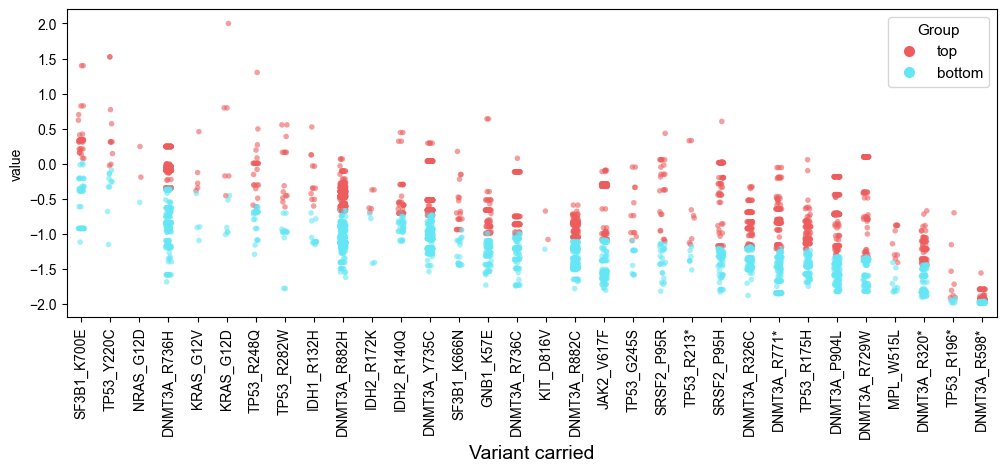

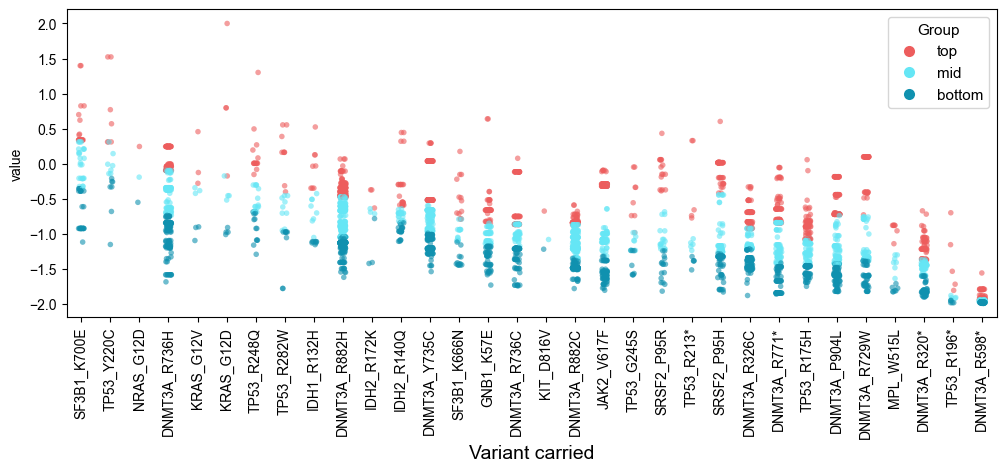

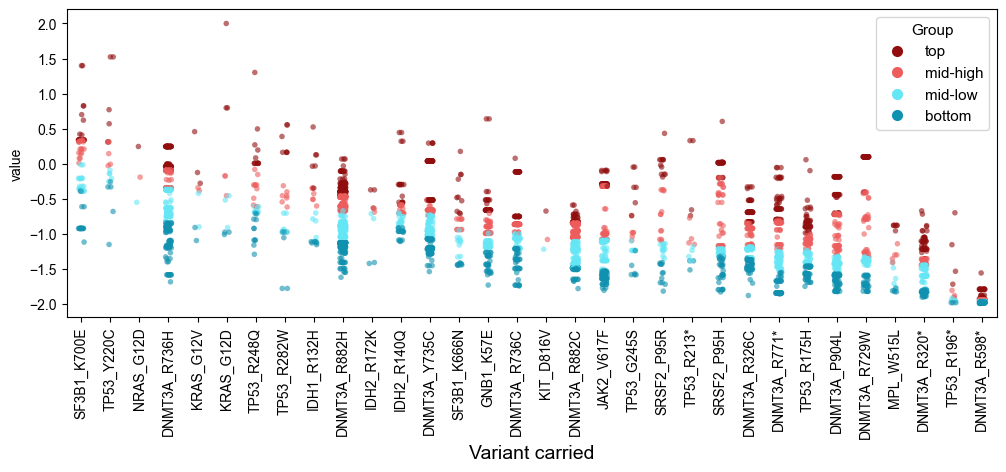

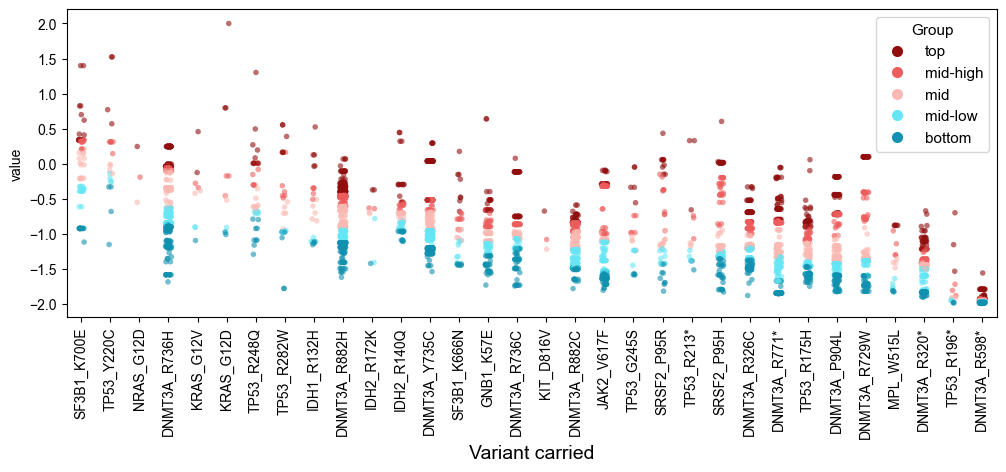

In [215]:

# create plots
colors2 = [col1, col2]
hue_order2 = ['top', 'bottom']
scores_groups2_eqsize = df_groups2_eqsize.sort_values(by = 'value', ascending = False)
plot_ranks(scores_groups2_eqsize, 'gene_var', 'value', 'group_name', colors2, order, 'jitter', hue_order2)

colors3 = [col1, col2, col3]
hue_order3 = ['top','mid', 'bottom']
scores_groups3_eqsize = df_groups3_eqsize.sort_values(by = 'value', ascending = False)
plot_ranks(scores_groups3_eqsize, 'gene_var', 'value', 'group_name', colors3, order, 'jitter', hue_order3)

colors4 = [col0, col1, col2, col3]
hue_order4 = ['top','mid-high', 'mid-low', 'bottom']
scores_groups4_eqsize = df_groups4_eqsize.sort_values(by = 'value', ascending = False)
plot_ranks(scores_groups4_eqsize, 'gene_var', 'value', 'group_name', colors4, order, 'jitter', hue_order4)

colors5 = [col0, col1, col1b, col2, col3]
hue_order5 = ['top', 'mid-high', 'mid', 'mid-low', 'bottom']
scores_groups5_eqsize = df_groups5_eqsize.sort_values(by = 'value', ascending = False)
plot_ranks(scores_groups5_eqsize, 'gene_var', 'value', 'group_name', colors5, order, 'jitter', hue_order5)

In [228]:

# add VAF data
batch_vafs = batch_gene_vars[['Person_ID', 'gene_var', 'VAF']]
df_groups2_eqsize.reset_index(inplace=True, drop=True)
df_groups2_eqsize = pd.merge(df_groups2_eqsize, batch_vafs, on = ['Person_ID', 'gene_var'])
df_groups3_eqsize.reset_index(inplace=True, drop=True)
df_groups3_eqsize = pd.merge(df_groups3_eqsize, batch_vafs, on = ['Person_ID', 'gene_var'])
df_groups4_eqsize.reset_index(inplace=True, drop=True)
df_groups4_eqsize = pd.merge(df_groups4_eqsize, batch_vafs, on = ['Person_ID', 'gene_var'])
df_groups5_eqsize.reset_index(inplace=True, drop=True)
df_groups5_eqsize = pd.merge(df_groups5_eqsize, batch_vafs, on = ['Person_ID', 'gene_var'])


In [229]:

# add column with VAF data 
df_groups2_eqsize['VAF_percent'] = df_groups2_eqsize['VAF'] * 100
df_groups3_eqsize['VAF_percent'] = df_groups3_eqsize['VAF'] * 100
df_groups4_eqsize['VAF_percent'] = df_groups4_eqsize['VAF'] * 100
df_groups5_eqsize['VAF_percent'] = df_groups5_eqsize['VAF'] * 100


In [197]:

def presents_variant(row, param):
    scores = {}
    if row[param] == 'top half': # indicates strong binding
       scores[f'presents_variant_{param}'] = True
    elif row[param] == 'top':
        scores[f'presents_variant_{param}'] = True
    else:
        scores[f'presents_variant_{param}'] = False
    return pd.Series(scores)


In [230]:

# now we switch this a little bit and plot all categories on one plot 

# for extreme groups in each split 
dfs_list = ['df_groups2_eqsize', 'df_groups3_eqsize', 'df_groups4_eqsize', 'df_groups5_eqsize']

for name in dfs_list:

    df = globals()[name]

    score = '-log10(%Rank_EL)'
    score_title = '-log10(%Rank_EL)'
    nr_groups = re.search(r'\d', name).group() # find the digit in the df name 

    # specify the colors 
    if nr_groups == '2':
        colors = [col1, col2]
    elif nr_groups == '3':
        colors = [col1, col2, col3]
    elif nr_groups == '4':
        colors = [col0, col1, col2, col3] 
    elif nr_groups == '5':
        colors = [col0, col1, col1b, col2, col3]

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]
        data = data.sort_values(by='VAF')
        
        N = data.shape[0]

        if N < 20:
            pass

        else:
            
            # add number of people in each category 
            data['group_size'] = data.groupby('group')['group'].transform('count')
            data['index_vaf_group'] = data.groupby('group')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
            
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', f'group', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', var, score, score_title, f'{nr_groups}_groups_eqsize_allon1')

    # plot aggregate for all variants
    df = df.sort_values(by='VAF')

    df['group_size'] = df.groupby('group')['group'].transform('count')
    df['index_vaf_group'] = df.groupby('group')['VAF'].rank(ascending=False) # index by VAF
    df['fraction_index_presenter_group'] = df['index_vaf_group'] / df['group_size']
    
    plot_cumulative(df, 'VAF_percent', 'fraction_index_presenter_group', f'group', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', 'all_variants', score, score_title, f'{nr_groups}_groups_eqsize_allon1') 

In [232]:

# now, divide everyone into binds strongly / weakly / does not bind based on score (< 0.5, < 2, > 2)
# thresholds are max 0.5 (for strong binding) and 2 (for weak binding)
threshold_strong = -1 * np.log10(1)
threshold_weak = -1 * np.log10(5)

conditions2 = [
    (df_groups5_eqsize['value'] > threshold_weak), # any binding (Jamie says they're getting binding with these)
    (df_groups5_eqsize['value'] <= threshold_weak) # no binding 
]
values2 = ['binding', 'no binding']
df_groups5_eqsize['binding_level2'] = np.select(conditions2, values2, default='unknown')


conditions3 = [
    (df_groups5_eqsize['value'] > threshold_strong),
    (df_groups5_eqsize['value'] > threshold_weak),
    (df_groups5_eqsize['value'] <= threshold_weak)
]
values3 = ['strong binding', 'weak binding', 'no binding']
df_groups5_eqsize['binding_level3'] = np.select(conditions3, values3, default='unknown')

# nb the scores are the same everywhere so it does not really matter on which dataframe you do it 


In [234]:

# okay no split based on threshold and plot for each variant and aggregate 

# now we switch this a little bit and plot all categories on one plot 

# for extreme groups in each split 

score = '-log10(%Rank_EL)'
score_title = '-log10(%Rank_EL)'

# specify the colors (not sure if I should use different ones given I have threshold stuff?)
variants = df_groups5_eqsize['gene_var'].unique()

# plot for each variant separately 
for var in variants: 

    data = df_groups5_eqsize[df_groups5_eqsize['gene_var'] == var]
    data = data.sort_values(by='VAF')
    
    # ignore cases where you have less than 5 cases in either category 
    if (data[data['binding_level2'] == 'binding'].shape[0] < 5 or data[data['binding_level2'] == 'no binding'].shape[0] < 5):
        pass

    else:
        # add number of people in each category 
        colors = [col0, col3]
        data['group_size_bind2'] = data.groupby('binding_level2')['binding_level2'].transform('count')
        data['index_vaf_group2'] = data.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group_bind2'] = data['index_vaf_group2'] / data['group_size_bind2']
        plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability {nr_groups} groups', var, score, score_title, f'{nr_groups}_groups_binding_2thresh')

    if (data[data['binding_level3'] == 'strong binding'].shape[0] < 5 or data[data['binding_level3'] == 'weak binding'].shape[0] < 5 or data[data['binding_level3'] == 'no binding'].shape[0] < 5):
        pass

    else:
        # add number of people in each category 
        colors = [col0, col1b, col3]
        data['group_size_bind3'] = data.groupby('binding_level3')['binding_level3'].transform('count')
        data['index_vaf_group3'] = data.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group_bind3'] = data['index_vaf_group3'] / data['group_size_bind3']
        plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', var, score, score_title, f'{nr_groups}_groups_binding_3thresh')


# plot aggregate for all variants
df_groups5_eqsize = df_groups5_eqsize.sort_values(by='VAF')
df_groups5_eqsize['index_vaf_group2'] = df_groups5_eqsize.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize['index_vaf_group3'] = df_groups5_eqsize.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize['group_size_bind2'] = df_groups5_eqsize.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize['group_size_bind3'] = df_groups5_eqsize.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize['fraction_index_presenter_group_bind2'] = df_groups5_eqsize['index_vaf_group2'] / df_groups5_eqsize['group_size_bind2']
df_groups5_eqsize['fraction_index_presenter_group_bind3'] = df_groups5_eqsize['index_vaf_group3'] / df_groups5_eqsize['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'all_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'all_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# okay so doing this by variant is a joke given how few cases with each variant across binding thresholds we are going to have
# BUT what I think would make sense is to divide up into substitutions (immunogenic) and stops (not immunogenic)
# BUT the problem with aggregation is that again, it may be that stuff that is not immunogenic reaches higher VAFs (higher intrinsic fitness variant etc etc.)

# STOP codons (expect no difference)
variants = set(df_groups5_eqsize.gene_var.tolist())
stops = ['DNMT3A_R320*', 'DNMT3A_R598*', 'DNMT3A_R771*','TP53_R213*', 'TP53_R196*']
subs = [var for var in variants if var not in stops]

# select for STOP codons
df_groups5_eqsize_stop = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(stops)]
df_groups5_eqsize_stop = df_groups5_eqsize_stop.sort_values(by='VAF')
df_groups5_eqsize_stop['index_vaf_group2'] = df_groups5_eqsize_stop.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_stop['index_vaf_group3'] = df_groups5_eqsize_stop.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_stop['group_size_bind2'] = df_groups5_eqsize_stop.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_stop['group_size_bind3'] = df_groups5_eqsize_stop.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_stop['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_stop['index_vaf_group2'] / df_groups5_eqsize_stop['group_size_bind2']
df_groups5_eqsize_stop['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_stop['index_vaf_group3'] / df_groups5_eqsize_stop['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_stop, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'stop_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_stop, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'stop_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# select for substitutions
df_groups5_eqsize_sub = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(subs)]
df_groups5_eqsize_sub = df_groups5_eqsize_sub.sort_values(by='VAF')
df_groups5_eqsize_sub['index_vaf_group2'] = df_groups5_eqsize_sub.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub['index_vaf_group3'] = df_groups5_eqsize_sub.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub['group_size_bind2'] = df_groups5_eqsize_sub.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_sub['group_size_bind3'] = df_groups5_eqsize_sub.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_sub['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_sub['index_vaf_group2'] / df_groups5_eqsize_sub['group_size_bind2']
df_groups5_eqsize_sub['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_sub['index_vaf_group3'] / df_groups5_eqsize_sub['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_sub, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'sub_variants', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_sub, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'sub_variants', score, score_title, f'{nr_groups}_groups_binding_3thresh') 

# what if we remove JAK2 from this 
# I would 100% conclude this is driven by JAK2 > don't do the same mistake that the cell people did!!!
subs_njk = [var for var in subs if var != 'JAK2_V617F']
df_groups5_eqsize_sub_njk = df_groups5_eqsize[df_groups5_eqsize.gene_var.isin(subs_njk)]
df_groups5_eqsize_sub_njk = df_groups5_eqsize_sub_njk.sort_values(by='VAF')
df_groups5_eqsize_sub_njk['index_vaf_group2'] = df_groups5_eqsize_sub_njk.groupby('binding_level2')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub_njk['index_vaf_group3'] = df_groups5_eqsize_sub_njk.groupby('binding_level3')['VAF'].rank(ascending=False) # index by VAF
df_groups5_eqsize_sub_njk['group_size_bind2'] = df_groups5_eqsize_sub_njk.groupby('binding_level2')['binding_level2'].transform('count')
df_groups5_eqsize_sub_njk['group_size_bind3'] = df_groups5_eqsize_sub_njk.groupby('binding_level3')['binding_level3'].transform('count')
df_groups5_eqsize_sub_njk['fraction_index_presenter_group_bind2'] = df_groups5_eqsize_sub_njk['index_vaf_group2'] / df_groups5_eqsize_sub_njk['group_size_bind2']
df_groups5_eqsize_sub_njk['fraction_index_presenter_group_bind3'] = df_groups5_eqsize_sub_njk['index_vaf_group3'] / df_groups5_eqsize_sub_njk['group_size_bind3']

colors = [col0, col3]
plot_cumulative(df_groups5_eqsize_sub_njk, 'VAF_percent', 'fraction_index_presenter_group_bind2', f'binding_level2', colors, 'VAF (%)', f'Cumulative probability', 'sub without JAK2', score, score_title, f'{nr_groups}_groups_binding_2thresh')
colors = [col0, col1b, col3]
plot_cumulative(df_groups5_eqsize_sub_njk, 'VAF_percent', 'fraction_index_presenter_group_bind3', f'binding_level3', colors, 'VAF (%)', f'Cumulative probability', 'sub without JAK2', score, score_title, f'{nr_groups}_groups_binding_3thresh') 


# Compare to randomly selected reference datasets 

In [270]:

# we can add scores to EVERYONE we have HLA genotype for in the UKBB data (this is the df_hla dataset)

# cases who have CH with a genotyped variant (from one of the ones we were looking at) are in batch_gene_vars 

ch_sampleids = batch_gene_vars['Person_ID']
ukbb_no_ch = df_clean_hla2[~df_clean_hla2['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare dataset with predictions (now just from NetMHC)
scores_netmhc_elrank = scores_[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
scores_netmhc_elrank_wide = pd.pivot(scores_netmhc_elrank, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')

hla_intersect = scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.isin(hla_ukbb)]
hla_intersect_list = hla_intersect.tolist() # select predictions for alleles which are available in NetMHC / PRIME

pred_sub_wide = scores_netmhc_elrank_wide[hla_intersect_list + scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.str.contains('gene_var_gt')].tolist()]

ukbb_no_ch_hla = ukbb_no_ch[hla_intersect]
ukbb_no_ch = pd.concat([ukbb_no_ch['Person_ID'], ukbb_no_ch_hla], axis = 1)
ukbb_no_ch.head()

ids_non_carriers_healthy = ukbb_no_ch.Person_ID.unique().tolist()
print('Number of healthy (non-CH) individuals examined:', len(ids_non_carriers_healthy))

# okay so now we have a dataset for everyone who does NOT have CH
# and for all of them, we have their alleles for which we can make predictions

# I am stupid and I can't move the index to the column so sorry but I will just a new column
pred_sub_wide['gene_var_gt'] = pred_sub_wide.index

Number of healthy (non-CH) individuals examined: 441608


In [283]:

# define new functions in case you want to get predictions for both CH and refseq

def find_best_score_for_all_variants_ref_ch(row, df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries
   
    # it may be that we don't have this column in case we are doing this for non-CH cases
   
    variants = df['gene_var_gt'] # get out variants which are present 
   
    scores = {} # initialise empy dictionaries

    # depending on the parameter, pick the minimum of maximum value 
    if param == "Aff_nM":
        for var in variants:
            # Find the minimum value for each variant in the category that is present
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            # Update the dictionary with the minimum value for the corresponding variant
            scores[f'score_{var}'] = best_value
        return pd.Series(scores)

    elif param == "Score_BA":
        for var in variants:
            
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value
        
        return pd.Series(scores)

    elif param == "Score_EL":
        for var in variants:
           
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_EL":
        for var in variants:
            
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


def find_best_score_all_variants_log_ref_ch(row, df, param):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries

    variants = df['gene_var_gt']
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":
        for var in variants:

            # take maximum of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            # take maxium of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "Aff_nM":
        for var in variants:

            # take maxium of the negative log score (low aff = more immunogenic)
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


In [308]:
# select only HLAs for which we have predictions
df_clean_hla2_hla = df_clean_hla2[hla_intersect]
df_clean_hla2_hla_sel = pd.concat([df_clean_hla2['Person_ID'], df_clean_hla2_hla], axis = 1)

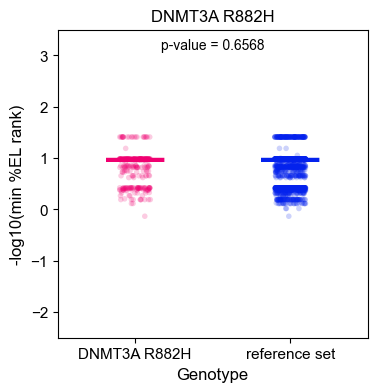

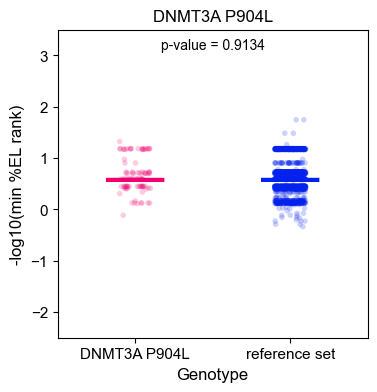

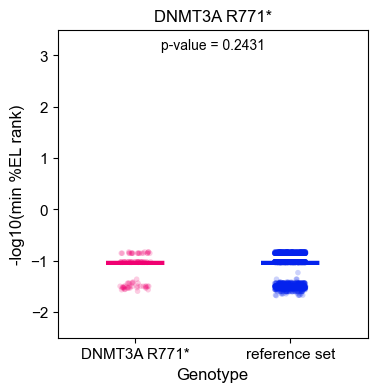

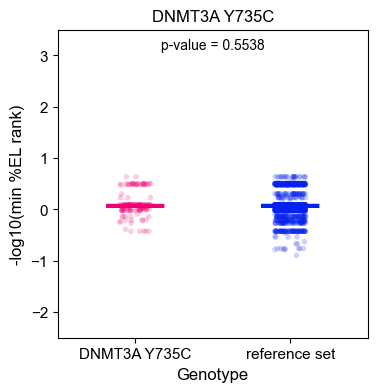

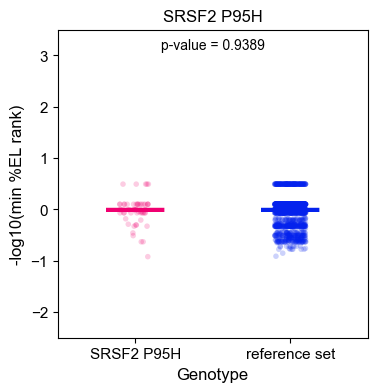

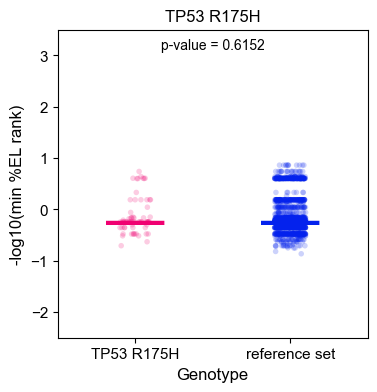

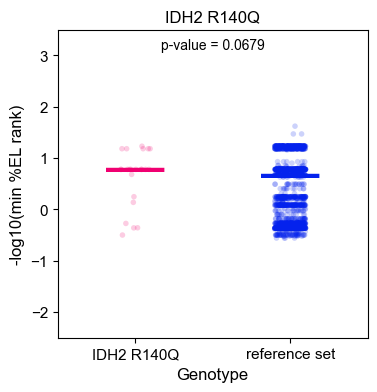

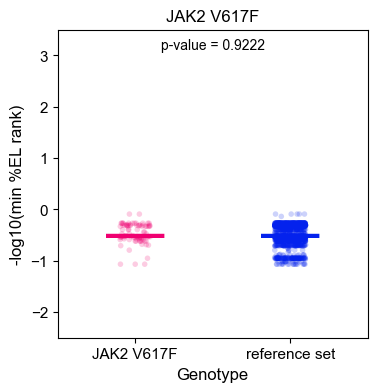

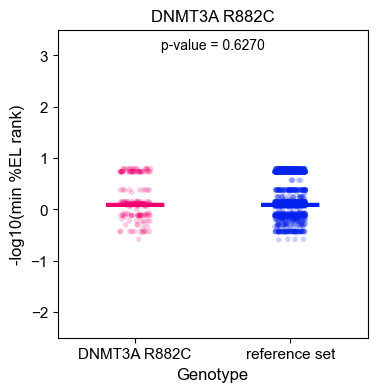

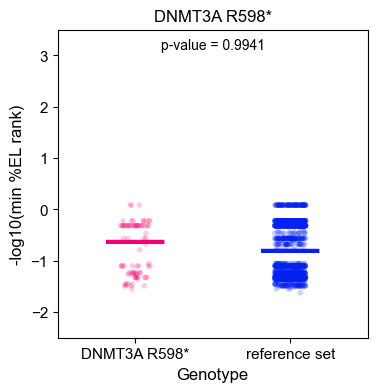

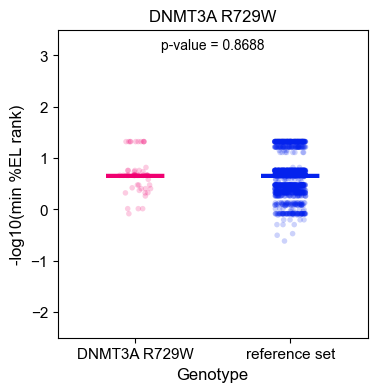

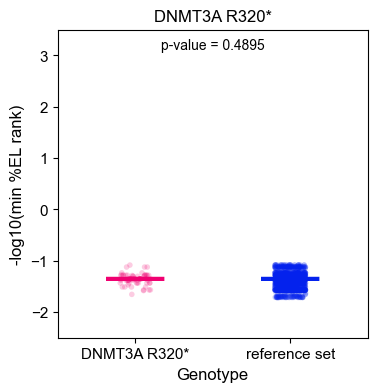

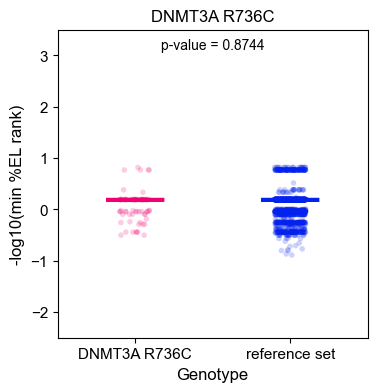

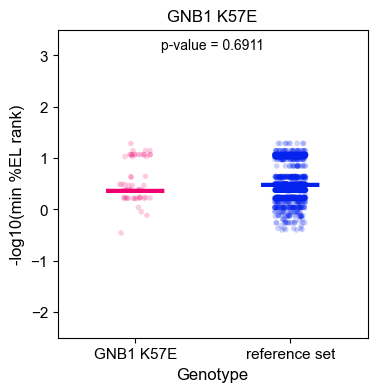

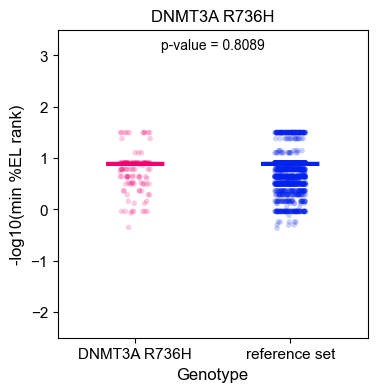

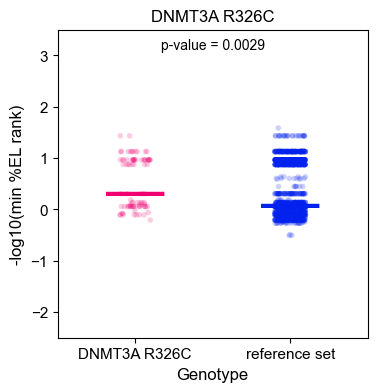

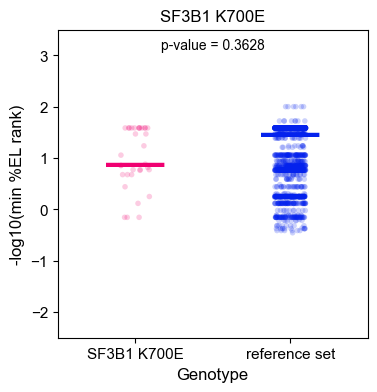

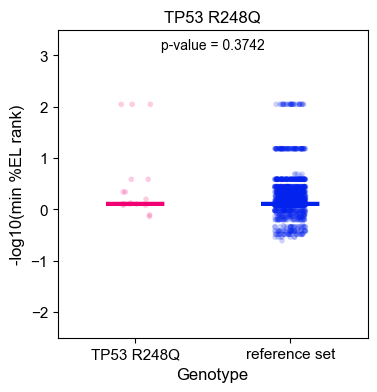

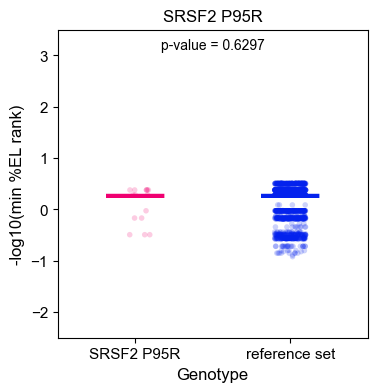

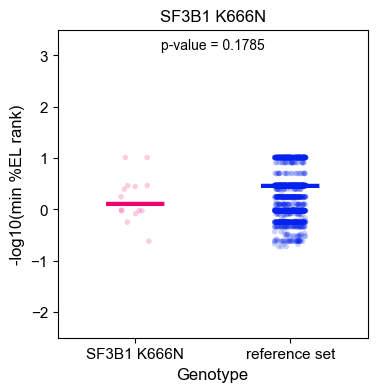

In [310]:

# new way of doing this where you do not sample 5x but you only sample ONE reference from EVERYONE who does not have this variant (CH with different variant or healthy)
# we use 2k for the reference to have a really good idea of how the distribution looks like 
# we also do the plot for all variants together 

# full script to look across variants  

np.random.seed(1) # ensure this is all reproducible 

# specify list of variants to look at 
variants = batch_gene_vars.gene_var.unique()
colors = ['#f00071', '#0422ed']
cols_ch = ['Person_ID', 'gene_var', 'score']

# initialize empty dataframe to store results in 
df_compare_to_ref = pd.DataFrame()

for var in variants:

    var_name = var.replace('_', ' ')
    
    # we will compare to %Rank EL (log) derived from NetMHC now
    ch_scores = ch_scores_melted_all_filtered[ch_scores_melted_all_filtered['gene_var'] == var]
    ch_scores = ch_scores[cols_ch]

    # identify number of variant carriers 
    n =  ch_scores.shape[0]

    if n > 10:

        # find all the dataset that you can sample from
        ids_non_carriers_ch = ch_scores_melted_all_filtered[ch_scores_melted_all_filtered['gene_var'] != var].Person_ID.unique().tolist()
        ids_non_carriers = ids_non_carriers_healthy + ids_non_carriers_ch
        ukbb_not_carrier = df_clean_hla2_hla_sel[df_clean_hla2_hla_sel.Person_ID.isin(ids_non_carriers)]
        ref = ukbb_not_carrier.sample(n=2000, replace=False) # no duplicates
            
        # specify parameter 
        param = '%Rank_EL'

        # add scores 
        ref_scores = pd.concat([ref, ref.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        ref_scores['gene_var'] = 'reference set'
        ref_scores.rename(columns={f'score_{var}_ch': 'score'}, inplace=True)
        ref_scores_var = ref_scores[cols_ch]
        
        # concatenate all dataframes
        scores_compare_all = pd.concat([ch_scores, ref_scores_var], axis=0)
        scores_compare_all["CH_variant_carrier"] = scores_compare_all['gene_var'] == var 
        scores_compare_all["CH_variant_carrier"] = scores_compare_all["CH_variant_carrier"].map({True: 'Carrier', False: 'Non-carrier'})

        # PLOTTING
        # calculate p value 
        scores_ch = scores_compare_all[scores_compare_all["CH_variant_carrier"] == 'Carrier'].score.tolist()
        scores_ref = scores_compare_all[scores_compare_all["CH_variant_carrier"] == 'Non-carrier'].score.tolist()
        H, p_value = mannwhitneyu(scores_ch, scores_ref)

        # format x axis for plotting 
        xaxis_labels = scores_compare_all.gene_var.str.replace('_', ' ')

        # jitterplot 
        plt.figure(figsize=(4,4)) # set figure size
        sns.stripplot(y=f'score', x=xaxis_labels, hue = "CH_variant_carrier", data=scores_compare_all, dodge = False, jitter = True, palette = colors, size = 4, alpha = 0.2, legend = False)
        
        plt.title(f'{var_name}')
        plt.xlabel(f'Genotype', fontsize = 12)
        plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
        plt.xticks(fontsize = 11)
        plt.yticks(fontsize = 11)
        plt.ylim(-2.5, 3.5)

        # add annotation to indicate median
        median_ch = ch_scores.score.median()
        median_ref = ref_scores_var.score.median()

        plt.text(0, median_ch, '—', ha='center', va='center', fontsize=42, color = '#f00071')
        plt.text(1, median_ref, '—', ha='center', va='center', fontsize=42, color = '#0422ed')

        # plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right')
        # legend = plt.gca().get_legend()
        # for lh in legend.legendHandles:
        #     lh.set_alpha(1)

        # add kruskall wallis test between groups 
        plt.text(0.5, 0.95, f'p-value = {p_value:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize = 10)
        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_{var}_compare_to_ref_set_2k_jitter.pdf', bbox_inches='tight')
        plt.close()
        
        # add rows to dataframe with data for all variants
        df_compare_to_ref = pd.concat([df_compare_to_ref, scores_compare_all], axis = 0)


In [360]:

# okay we need to add a colum with the variant for everyone (because you have reference sets to a variant but the gene_var column does not say which variant this is reference for)
labels = []
current_label = None

# Iterate through the DataFrame
for idx, row in df_compare_to_ref.iterrows():
    # If the category is 'ch', update the current label
    if row['CH_variant_carrier'] == 'Carrier':
        current_label = row['gene_var']
    # Append the current label to the list
    labels.append(current_label)

# Add the labels list as a new column to the DataFrame
df_compare_to_ref['CH variant'] = labels

# add mutation type 
def add_mut_type(string):
    if string[-1] == '*':
        return 'stop codon'
    else:
        return 'substitution'

# Add column based on the last character of strings in the 'var' column
df_compare_to_ref['mutation_type'] = df_compare_to_ref['CH variant'].apply(add_mut_type)

In [370]:

# figure out desired order of variants on the plot 
ch_all_el_rank_log_melted_sort['median_score'] = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
ch_all_el_rank_log_melted_sort_sort = ch_all_el_rank_log_melted_sort.sort_values(by='median_score', ascending = False)
order = ch_all_el_rank_log_melted_sort_sort.gene_var.unique()
variants_examined = df_compare_to_ref['CH variant'].unique().tolist()
order_2 = [var for var in order if var in variants_examined]


In [371]:
df_compare_to_ref

,Person_ID,gene_var,score,CH_variant_carrier,CH variant,mutation_type
298,1915223,DNMT3A_R882H,-0.134814,Carrier,DNMT3A_R882H,substitution
11,2120797,DNMT3A_R882H,0.112946,Carrier,DNMT3A_R882H,substitution
32,2189551,DNMT3A_R882H,0.112946,Carrier,DNMT3A_R882H,substitution
5,2100679,DNMT3A_R882H,0.189096,Carrier,DNMT3A_R882H,substitution
90,1549070,DNMT3A_R882H,0.189096,Carrier,DNMT3A_R882H,substitution
...,...,...,...,...,...,...
56797,3713252,reference set,0.463442,Non-carrier,SF3B1_K666N,substitution
362585,4525411,reference set,1.008774,Non-carrier,SF3B1_K666N,substitution
39748,3930345,reference set,1.008774,Non-carrier,SF3B1_K666N,substitution
400426,2067267,reference set,0.463442,Non-carrier,SF3B1_K666N,substitution


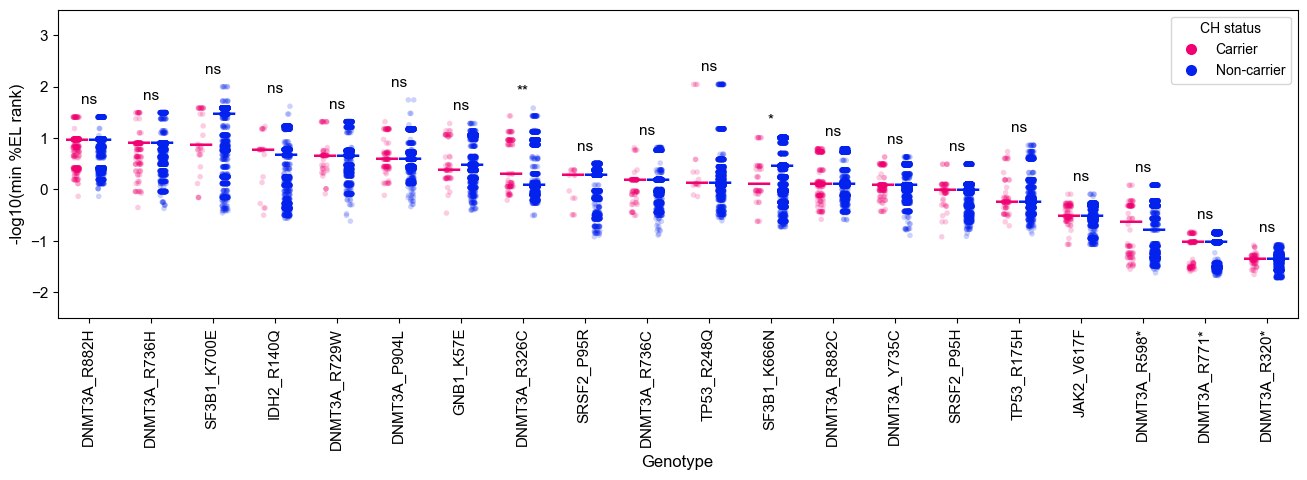

In [373]:

# plot for all variants together 

# jitterplot 
# facet by mutation type 

colors = ['#f00071', '#0422ed']

plt.figure(figsize=(16,4)) # set figure size
sns.stripplot(y=f'score', x='CH variant', hue = 'CH_variant_carrier', data=df_compare_to_ref, dodge = True, jitter = True, palette = colors, size = 4, alpha = 0.2, legend = True, order = order_2)

plt.xlabel(f'Genotype', fontsize = 12)
plt.ylabel(f'-log10(min %EL rank)', fontsize = 12)
plt.xticks(fontsize = 11, rotation = 90)
plt.yticks(fontsize = 11)
plt.ylim(-2.5, 3.5)

# add annotation to indicate median

for i, category in enumerate(order_2):
            
    median_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.median()
    median_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.median()

    # Plot text for each hue group
    plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#f00071')
    plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=16, fontweight='bold', color = '#0422ed')

# add kruskall wallis test between groups 
for i, category in enumerate(order_2):
    
    category_data = df_compare_to_ref[df_compare_to_ref['CH variant'] == f'{category}']
    max_value = category_data['score'].max()

    scores_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.tolist()
    scores_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.tolist()

    statistic, p_value = mannwhitneyu(scores_carrier, scores_noncarrier)
    significance = ''
    if p_value > 0.05:
        significance = 'ns'
    elif p_value < 0.01:
        significance = '**'
    else:
        significance = '*'
    plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right')
legend = plt.gca().get_legend()
for lh in legend.legendHandles:
    lh.set_alpha(1)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_method_UKBB_{param}_for_all_compare_to_ref_set_2k_jitter.pdf', bbox_inches='tight')


# MHC genotype > effect on CH risk 

In [377]:


# define a new function just to do it for one variant 
def find_best_score_one_variant_log_ref_ch(row, df, param, variant):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carrie
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":

        # take maximum of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "%Rank_BA":
        
        # take maxium of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "Aff_nM":
        
        # take maxium of the negative log score (low aff = more immunogenic)
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)


In [395]:

# define a function to split people into groups based on MHC presentation score 

def split_equal_groups_by_varscore(df, num_groups, var):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    
    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    return group_assignments


In [388]:

# for everyone in the UKBB, add binding score for each variant based on their MHC genotype
df_clean_hla1_hla_sel_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = 'DNMT3A_R882H_ch', axis=1)], axis=1)

# order the df by rank
df_clean_hla1_hla_sel_scores['rank'] = df_clean_hla1_hla_sel_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
df_clean_hla1_hla_sel_scores_sort = df_clean_hla1_hla_sel_scores.sort_values(by = 'rank')


In [1]:
# split people into 3 or 4 groups for each variant (how strongly they bind)
df_clean_hla1_hla_sel_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 2, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_3'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 3, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_4'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 4, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_5'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 5, var = 'DNMT3A_R882H')
df_clean_hla1_hla_sel_scores_sort['groups_10'] = split_equal_groups_by_varscore(df_clean_hla1_hla_sel_scores_sort, num_groups = 10, var = 'DNMT3A_R882H')

# okay now we need to add a column to indicate if that person has CH driven by this variant
ids_DNMT3A_R882H = batch_gene_vars[batch_gene_vars['gene_var']=='DNMT3A_R882H'].Person_ID.tolist()
df_clean_hla1_hla_sel_scores_sort['DNMT3A_R882H_positive'] = df_clean_hla1_hla_sel_scores_sort.Person_ID.isin(ids_DNMT3A_R882H) # added True if someone has the variant, False otherwise 

NameError: name 'split_equal_groups_by_varscore' is not defined

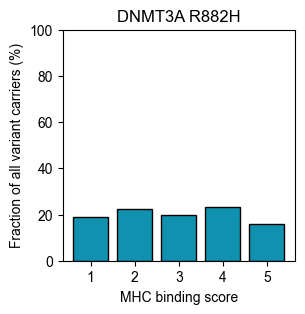

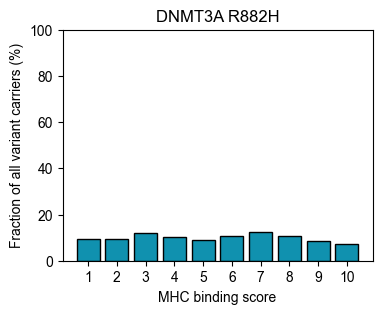

: 

In [433]:

# now, you can calculate how many people with CH (out of all CH positive cases for this variant) are in each group
DNMT3A_R882H_counts5 = df_clean_hla1_hla_sel_scores_sort.groupby('groups_5')['DNMT3A_R882H_positive'].sum().reset_index()
DNMT3A_R882H_counts5['percentage_all_cases'] = DNMT3A_R882H_counts5.DNMT3A_R882H_positive / df_clean_hla1_hla_sel_scores[df_clean_hla1_hla_sel_scores['DNMT3A_R882H_positive'] == True].shape[0] * 100
DNMT3A_R882H_counts5
plt.figure(figsize = (3,3))
plt.bar(DNMT3A_R882H_counts5['groups_5'], DNMT3A_R882H_counts5['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
plt.ylim(0, 100)
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('MHC binding score')
plt.ylabel('Fraction of all variant carriers (%)')
plt.title('DNMT3A R882H')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group5.pdf', bbox_inches='tight')

DNMT3A_R882H_counts10 = df_clean_hla1_hla_sel_scores_sort.groupby('groups_10')['DNMT3A_R882H_positive'].sum().reset_index()
DNMT3A_R882H_counts10['percentage_all_cases'] = DNMT3A_R882H_counts10.DNMT3A_R882H_positive / df_clean_hla1_hla_sel_scores[df_clean_hla1_hla_sel_scores['DNMT3A_R882H_positive'] == True].shape[0] * 100
DNMT3A_R882H_counts10
plt.figure(figsize = (4,3))
plt.bar(DNMT3A_R882H_counts10['groups_10'], DNMT3A_R882H_counts10['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
plt.ylim(0, 100)
plt.xlabel('MHC binding score')
plt.ylabel('Fraction of all variant carriers (%)')
plt.title('DNMT3A R882H')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group10.pdf', bbox_inches='tight')

In [ ]:
# loop for all variants

variants = 

for var in variants:
    # for everyone in the UKBB, add binding score for each variant based on their MHC genotype
    df_all_ukbb_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = f'{var}_ch', axis=1)], axis=1)

    # order the df by rank
    df_all_ukbb_scores['rank'] = df_all_ukbb_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
    df_all_ukbb_scores_sort = df_all_ukbb_scores.sort_values(by = 'rank')

    # split people into 3 or 4 groups for each variant (how strongly they bind)
    df_all_ukbb_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 2, var = var)
    df_all_ukbb_scores_sort['groups_3'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 3, var = var)
    df_all_ukbb_scores_sort['groups_4'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 4, var = var)
    df_all_ukbb_scores_sort['groups_5'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 5, var = var)
    df_all_ukbb_scores_sort['groups_10'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 10, var = var)

    # okay now we need to add a column to indicate if that person has CH driven by this variant
    DNMT3A_R882H_counts5 = df_clean_hla1_hla_sel_scores.groupby('groups_5')['DNMT3A_R882H_positive'].sum().reset_index()
    ids_DNMT3A_R882H = batch_gene_vars[batch_gene_vars['gene_var']=='DNMT3A_R882H'].Person_ID.tolist()
    df_clean_hla1_hla_sel_scores['DNMT3A_R882H_positive'] = df_clean_hla1_hla_sel_scores.Person_ID.isin(ids_DNMT3A_R882H) # added True if someone has the variant, False otherwise 

    # now, you can calculate how many people with CH (out of all CH positive cases for this variant) are in each group
    DNMT3A_R882H_counts5['percentage_all_cases'] = DNMT3A_R882H_counts5.DNMT3A_R882H_positive / df_clean_hla1_hla_sel_scores[df_clean_hla1_hla_sel_scores['DNMT3A_R882H_positive'] == True].shape[0] * 100
    DNMT3A_R882H_counts5
    plt.figure(figsize = (3,3))
    plt.bar(DNMT3A_R882H_counts5['groups_5'], DNMT3A_R882H_counts5['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel('MHC binding score')
    plt.ylabel('Fraction of all variant carriers (%)')
    plt.title('DNMT3A R882H')
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group5.pdf', bbox_inches='tight')

    DNMT3A_R882H_counts10 = df_clean_hla1_hla_sel_scores.groupby('groups_10')['DNMT3A_R882H_positive'].sum().reset_index()
    DNMT3A_R882H_counts10['percentage_all_cases'] = DNMT3A_R882H_counts10.DNMT3A_R882H_positive / df_clean_hla1_hla_sel_scores[df_clean_hla1_hla_sel_scores['DNMT3A_R882H_positive'] == True].shape[0] * 100
    DNMT3A_R882H_counts10
    plt.figure(figsize = (4,3))
    plt.bar(DNMT3A_R882H_counts10['groups_10'], DNMT3A_R882H_counts10['percentage_all_cases'], color = '#1091af', edgecolor = 'black')
    plt.ylim(0, 100)
    plt.xlabel('MHC binding score')
    plt.ylabel('Fraction of all variant carriers (%)')
    plt.title('DNMT3A R882H')
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure4/{timestr}/{timestr}_compare_fraction_cases_by_mhc_bind_DNMT3A_R882H_group10.pdf', bbox_inches='tight')
